In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from IPython.display import Markdown as md
from ipywidgets import FloatProgress
from IPython.display import display

# 1. Monte Carlo method

Although the idea is to use genetic algorithms, Monte Carlo (or the random search method) has been widely used to optimize functions (amongst other related topics in engineering). In the next example, $\pi$ will be obtained by 'throwing' points in the $x, y = [0, 1]$ square. The idea is to take those which are inside the unit circle with radius $r=1$ (or in the simplified case, a fourth of the circle) and use them to obtain the value of $\pi$. The idea is compare the area that points fill in the circle with respect to the square of length $l=1$:

$$
\dfrac{A_{{circ/4}}}{A_{sq}} = \dfrac{(\pi r^2)/4}{l^2} = \dfrac{(\pi \cdot 1^2)/4}{1\cdot 1} = \dfrac{\pi}{4} \longrightarrow \pi = 4 \cdot \dfrac{A_{{circ/4}}}{A_{sq}} \longrightarrow \pi \simeq  4 \cdot \dfrac{\#pts_{{circ/4}}}{\#pts_{sq}} 
$$

In [2]:
# boundary between the square and the circle
circX = np.linspace(0,1,500)
circY = np.sqrt(1-circX**2)

In [3]:
def MonteCarlo (noPoints, plot):
    # function to apply the Monte Carlo method to the pi-cicrle-square case
    # inputs are the number of points and if the plot is desired (plot='y') or not

    # create random points inside the square
    x = np.random.random(noPoints)
    y = np.random.random(noPoints)

    # create a counter for the ones inside the circle
    count = 0

    # loop over all the points
    for i in range(noPoints):
        # and increment the counter if it is inside the circle
        if x[i]**2 + y[i]**2 <= 1:
            count += 1

    # compute the approximation of pi
    appPi = (4*count/noPoints)
    # and the error with the true pi value
    error = abs(np.pi-appPi)/np.pi*100
    
    # if the plot is desired
    if plot == 'y':
        # show the graphical result
        fig, ax = plt.subplots(1, figsize = (4,4), dpi = 100)
        ax.fill_between(circX, 0, circY, alpha = 0.3, color = 'r')
        ax.fill_between(circX, circY, 1, alpha = 0.3, color = 'b')
        ax.scatter(x, y, color='k', marker='.', s = 1)
        ax.set_title(r'#pts = %i    $\pi$ = %.4f    $\varepsilon$=%.2f %%' %(noPoints, appPi, error))
        ax.set_xlim([0,1.0])
        ax.set_ylim([0,1.0])
        # and don't get any other outpuut
    # if the plot is not desired
    else:
        # return the approximaate value of pi
        return appPi

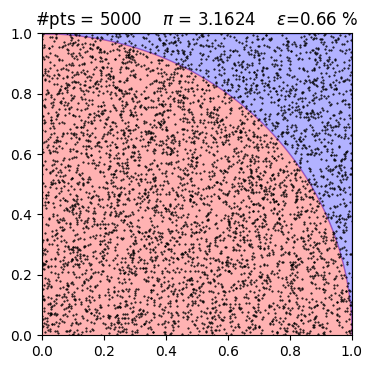

In [4]:
# sample callto the function
MonteCarlo(5000, 'y')
# note that each call will yield different results due to the stochasticity of the method

In [5]:
# given that it is an stochastic process, lets run the case 'executions' times for 'noPoints' points each time
executions = 25
noPoints = 50

# preallocate space for the computed value of pi with the Monte Carlo method
computedPi = np.zeros((noPoints,executions))

# create a vector with the value for each 'noPoints' in logarithmic scale
samples = np.logspace(1,5,noPoints)

# call the function for each number of points
for i in range(noPoints):
    # certain number of times
    for j in range(executions):
        # and store the obtained results
        computedPi[i,j] = MonteCarlo(int(samples[i]), 'n')
        # casting is done to the number of points to have an integer

In [6]:
# compute the error for each evaluation
errorPi = abs(np.pi-computedPi)/np.pi*100

# preallocate space for the both the error ...
mean = np.zeros(np.shape(computedPi)[0])
std = np.zeros(np.shape(computedPi)[0])

# ... and the true pi value
meanPi = np.zeros(np.shape(computedPi)[0])
stdPi = np.zeros(np.shape(computedPi)[0])

# loop over all 'number of points' and compute the mean and std for the solutions
for i in range(np.shape(computedPi)[0]):
    mean[i] = np.mean(errorPi[i,:])
    meanPi[i] = np.mean(computedPi[i,:])
    std[i] = np.std(errorPi[i,:])
    stdPi[i] = np.std(computedPi[i,:])

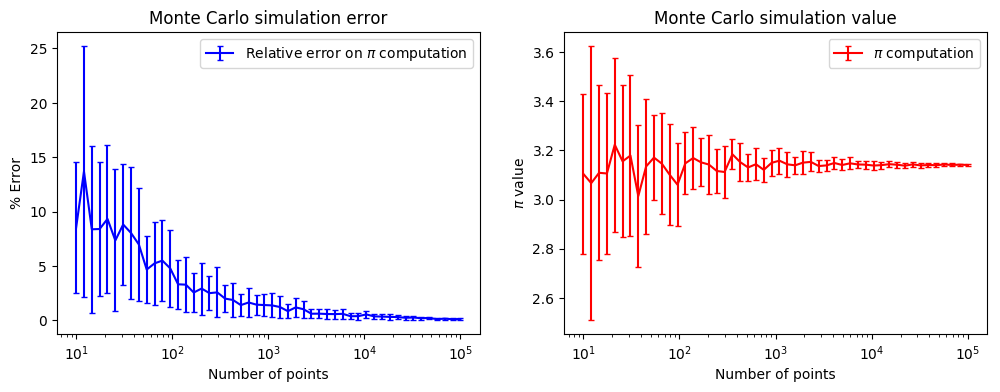

In [7]:
# show up the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,4), dpi = 100)

# error
ax1.errorbar(samples, mean, std, color='b', label='Relative error on $\pi$ computation', capsize = 2)
ax1.set_xlabel('Number of points')
ax1.set_ylabel('% Error')
ax1.set_title('Monte Carlo simulation error')
ax1.legend()
ax1.set_xscale("log", nonposx='clip')

# pi value
ax2.errorbar(samples, meanPi, stdPi, color='r', label='$\pi$ computation', capsize = 2)
ax2.set_xlabel('Number of points')
ax2.set_ylabel('$\pi$ value')
ax2.set_title('Monte Carlo simulation value')
ax2.legend()
ax2.set_xscale("log", nonposx='clip')

# 2. Known function optimization - Monte Carlo approach

Knowing the value of $\pi$ serve as a first approach, burt lets move to a simple problem. Let's try to find the maximum value of a known function. Although in the CFD simulations the function will not be known, an input of points will go through the $\texttt{solver}$ and will return the real value, having a black-box system.

The code will be developed for the function:

$$
f(x, y) = \exp\left(-\dfrac{1}{3}x^3+x-y^2\right)
$$

and afterwards tried with some of the [typical optimization functions](https://en.wikipedia.org/wiki/Test_functions_for_optimization) to analyze performance. 

In [8]:
# define the function
def ex_function(x,y):
    return np.exp(-x**3/3+x-y**2)

A squared grid is created to evaluate the fucntion. It is restricted to $x\in (-1.8,5.2)$ and $y\in (-3.5,3.5)$. It can be seen that the function has a LOCAL maximum value at $(1,0)$, but it has some asymptoticc behaviour for higher negative values in the $-x$ direction. This will include some complexity for the optimization method.

Text(0.5,1,'Contour Plot')

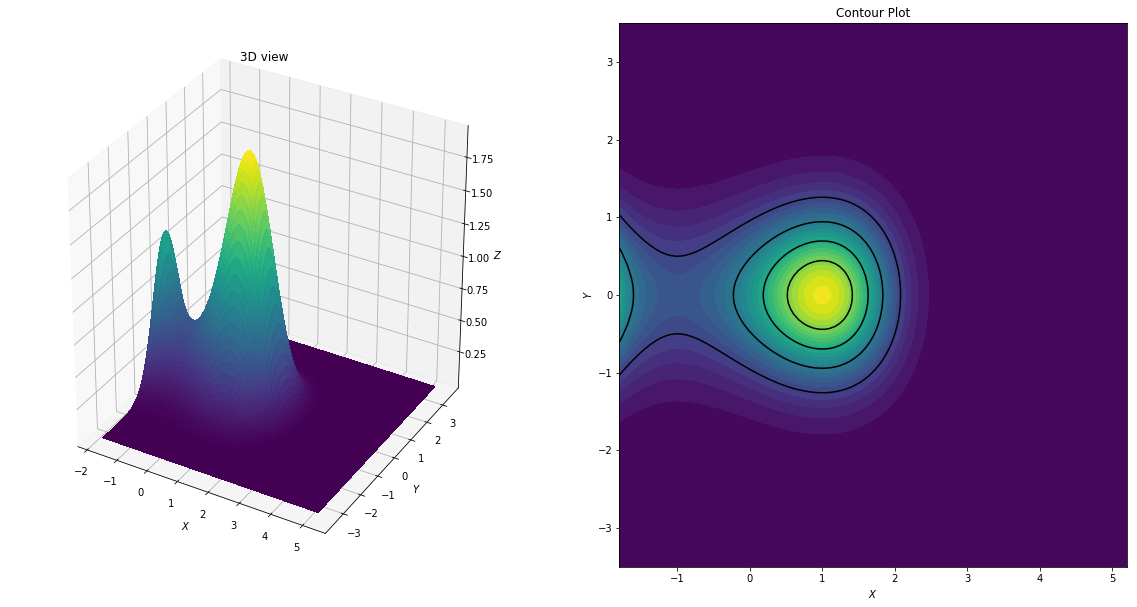

In [9]:
# create the grid where the optimization will be performed
x = np.linspace(-1.8,5.2,100)
y = np.linspace(-3.5,3.5,100)
X, Y = np.meshgrid(x,y)

# evaluate the function
Z = ex_function(X, Y)

# set the levels for the contour plot
levels = 25

# plot the 3D view and the contour plot of the function
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, Z, rstride = 1, cstride = 1, cmap = cm.viridis, linewidth = 0, antialiased = False)
ax1.set_xlabel('$X$')
ax1.set_ylabel('$Y$')
ax1.set_zlabel('$Z$')
ax1.set_title('3D view')

ax2 = fig.add_subplot(1, 2, 2)
ax2.contourf(X, Y, Z, levels, cmap = cm.viridis, antialiased = False)
ax2.contour(X, Y, Z, int(levels/5) if levels>10 else 10, colors='k')
ax2.set_xlabel('$X$')
ax2.set_ylabel('$Y$')
ax2.set_title('Contour Plot')

In [10]:
def classical_MC_optimization (function, noPoints, x, y, X, Y, Z, plotOp, savePlot):
    ''' Function to maximize a function with the Monte Carlo method
    Inputs:
       function: function to be maximized
       noPoints: number of points to be used
       x: x-axis range for the search method
       y: y-axis range for the search method
       X: meshgrid for plotting options
       Y: meshgrid for plotting options
       Z: evaluated meshgrid
       plotOp: flag to select if the plot is to be computed
       savePlot: flag to select if the plot is to be saved
    
    Output:
        error: value of the error of the best located point'''
    
    # random distributed grid with the specified number of points
    xi = np.random.uniform(x[0], x[-1], noPoints)
    yi = np.random.uniform(y[0], y[-1], noPoints)
    
    # real value of the function
    zi = function(xi,yi)
    
    # the maximum point is choosen as the better one to perform the error calculation
    # as maximum is located in (x,y)=(1,0), the distance from the maximum point is computed
    error = np.sqrt((xi[zi.argmax()]-1)**2+(yi[zi.argmax()]-0)**2)
    
    # plotting section of the function if desired   
    if plotOp == 'y' or plotOp == 'yes':
        fig, ax = plt.subplots(1, figsize=((4, 4)), dpi=100)
        ax.contourf(X, Y, Z, 10, cmap = cm.binary)
        ax.plot(xi,yi,'b.',markersize = 2)
        ax.plot(xi[zi.argmax()],yi[zi.argmax()],'.', color='yellow', markersize = 7)
        ax.set_xlabel('$X$')
        ax.set_ylabel('$Y$')
        ax.set_xlim(x[0], x[-1])
        ax.set_ylim(y[0], y[-1])
        ax.set_title('Monte Carlo simulation, $\epsilon$=%.4f' %(error)) 
    
    # save the figure if desired
    if savePlot == 'y' or savePlot == 'yes':
        plt.savefig('classicalMCsimulation.png', bbox_inches = 'tight', dpi=200)

    # return the error of the optimization
    return error

0.4692752940331225

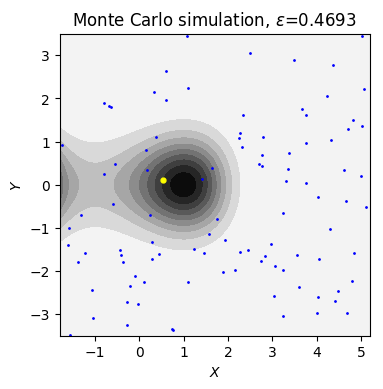

In [11]:
# sample call to the funtion
classical_MC_optimization(ex_function, 100, x, y, X, Y, Z, 'yes', 'no')

A set of simulations will be carried out to know the performance of this method. Points will go from 10 to 100 and the error for each simulation will be computed. The total number of evaluations for each number of points will be the same as the number of points, having a squared $n\times n$ matrix to store the data.

In [12]:
# number of simulations (which will be number of points with which the random search is performed)
noSim = 100

# create a logarithmic spacing with noSim elemments
initialPointsClassicalMC = np.logspace(1,4,noSim)
# preallocate space for [initial points, simulations]
cMCopt = np.zeros((noSim,noSim))

# progress bar for the process
iter_val = FloatProgress(min=0, max=noSim*noSim)
display(iter_val)

# call the function for each 'number of points'
for h in range(np.shape(cMCopt)[0]):
    # a 'number of points' times for statistical analysis
    for i in range(np.shape(cMCopt)[1]):
        # saving the ouput 
        cMCopt[h,i] = classical_MC_optimization(ex_function, int(initialPointsClassicalMC[h]), x, y, X, Y, Z, 'nope', 'nope')
        # and adding an iteration to the progress bar
        iter_val.value += 1

FloatProgress(value=0.0, max=10000.0)

In [13]:
# preallocate space for [initial points, (EVmean, EVstd)]
cMCopt_error = np.zeros((noSim, 2)) 

# loop for all the 'number of points'
for h in range(np.shape(cMCopt)[0]):
    # compute the mean and standard deviation
    cMCopt_error[h,0] = np.mean(cMCopt[h,:])
    cMCopt_error[h,1] = np.std(cMCopt[h,:])

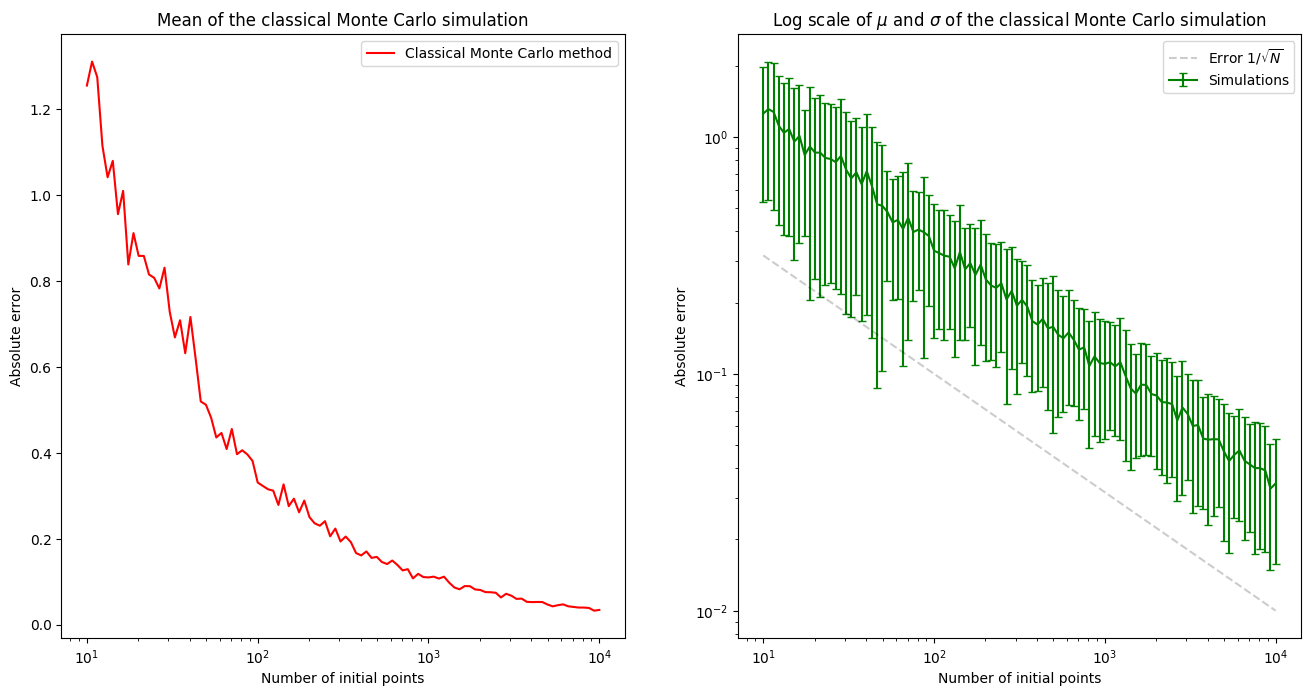

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=((16,8)), dpi = 100)

# plot the results in a semilogx scale
ax1.semilogx(initialPointsClassicalMC, cMCopt_error[:,0], color = 'r', label=r'Classical Monte Carlo method')
ax1.set_xlabel('Number of initial points')
ax1.set_ylabel('Absolute error')
ax1.set_title('Mean of the classical Monte Carlo simulation')
ax1.legend()

# to better see the trend (usually defined as 1/sqrt(N)) use log-log scaling
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.errorbar(initialPointsClassicalMC, cMCopt_error[:,0], cMCopt_error[:,1], color = 'g', capsize = 3, label=r'Simulations')
ax2.plot(initialPointsClassicalMC, 1/np.sqrt(initialPointsClassicalMC), 'k--', alpha=0.2, label=r'Error $1/\sqrt{N}$')
ax2.set_xlabel('Number of initial points')
ax2.set_ylabel('Absolute error')
ax2.set_title('Log scale of $\mu$ and $\sigma$ of the classical Monte Carlo simulation')
ax2.legend()

It can be seen that error is not to high, but in order to achieve high precission, the required number of evaluations (intial points) must be high.

# 3. Known function optimization - optimized Monte Carlo approach

If instead of throwing an incredibly enormous number of points to 'luckily' hit the maximum, a more intelligent approach can be used to reduce the number of evaluations. Using the Monte Carlo method mixed with an evolutionary approach, the process may be: an initial set of points is randomly created, the best points of the $i$ generation are choosen to create a normal distribution in 2D (with $\mu$ and $\sigma$), the points of generation $i+1$ are created from both random and normal distribution, reaching eventualy the desired precision.

In [15]:
def opt_MC_optimization(function, noPoints, tol, genLim, x, y, X, Y, Z, plotOp, savePlot):
    ''' Function to maximize a function with an optimized Monte Carlo method
    Inputs:
       function: function to be maximized
       noPoints: number of points to be used
       tol: required tolerance
       genLim: upper bound for the number of generations
       x: x-axis range for the search method
       y: y-axis range for the search method
       X: meshgrid for plotting options
       Y: meshgrid for plotting options
       Z: evaluated meshgrid
       plotOp: flag to select if the plot is to be computed
       savePlot: flag to select if the plot is to be saved
    
    Output:
        error: value of the error of the best located point'''
    
    # define the genetion counter as one      
    gen = 1

    # random distributed grid with the specified number of points
    xi = np.random.uniform(x[0], x[-1], noPoints)
    yi = np.random.uniform(y[0], y[-1], noPoints)
    
    # evaluate the function
    zi = function(xi,yi)
    
    # take the best specimenes from the sample
    # the number of points to choose is described by:
    selectPoints = int(round((noPoints/2.5)*(np.tanh(gen/10-1)+1)))
    
    # if only one point is choosen, mean and convariance are unfeasible
    if selectPoints <= 1: 
        selectPoints = 2 
        
    # points are ordered and the 'selectPoints' maximum values are choosen
    xbest = xi[np.argsort(zi)[-selectPoints:]]
    ybest = yi[np.argsort(zi)[-selectPoints:]]

    # compute the mean and covariance of the best selected data
    mean = np.array([np.mean(xbest), np.mean(ybest)])
    cov = np.cov(xbest,ybest)
    
    # with the mean and covariance values, run a multivariate_normal distribution
    normal = np.random.multivariate_normal(mean, cov, selectPoints)

    # compute the error to establish a stop criteria
    error = np.sqrt((xi[np.argsort(zi)[-1:]]-1)**2+(yi[np.argsort(zi)[-1:]]-0)**2)
    
    # plotting section of the function (if desired) 
    if plotOp == 'y' or plotOp == 'yes':
        fig, ax = plt.subplots(figsize=(20, 4*int(np.ceil(genLim/5))), dpi=100)
        plt.subplot(int(np.ceil(genLim/5)), 5, gen)
        plt.contourf(X, Y, Z, 10, cmap = cm.binary)
        plt.plot(xi,yi,'b.',markersize = 2)
        plt.plot(xi[np.argsort(zi)[-selectPoints:]],yi[np.argsort(zi)[-selectPoints:]],'r.',markersize=4)
        plt.plot(xi[np.argsort(zi)[-1:]],yi[np.argsort(zi)[-1:]],'.',color='yellow',markersize = 7)
        plt.xlabel('$X$')
        plt.ylabel('$Y$')
        plt.xlim(x[0], x[-1])
        plt.ylim(y[0], y[-1])
        plt.title('%i-th generation, $\epsilon$=%.4f' %(gen, error))      

    # while the number of generations or the tolerance is not reached
    while error > tol and gen < genLim:
        # advance the generation counter
        gen += 1
    
        # combine the random distributed with the normal distributed points
        xi = np.concatenate([np.random.uniform(x[0], x[-1], noPoints-selectPoints), normal[:,0]])
        yi = np.concatenate([np.random.uniform(y[0], y[-1], noPoints-selectPoints), normal[:,1]])
        
        # restrict the search boundaries to the specified values in vectors x and y
        xi[xi < x[0]] = x[0]
        xi[xi > x[-1]] = x[-1]
        yi[yi < y[0]] = y[0]
        yi[yi > y[-1]] = y[-1]
    
        # evaluate the function
        zi = function(xi,yi)

        # take the best specimenes from the sample
        # the number of points to choose is described by:
        selectPoints = int(round((noPoints/2.5)*(np.tanh(gen/10-1)+1)))

        # if only one point is choosen, mean and convariance are unfeasible
        if selectPoints <= 1: 
            selectPoints = 2 

        # points are ordered and the 'selectPoints' maximum values are choosen
        xbest = xi[np.argsort(zi)[-selectPoints:]]
        ybest = yi[np.argsort(zi)[-selectPoints:]]

        # compute the mean and covariance of the best selected data
        mean = np.array([np.mean(xbest), np.mean(ybest)])
        cov = np.cov(xbest,ybest)

        # compute the mean and covariance of the best selected data
        normal = np.random.multivariate_normal(mean, cov, selectPoints)

        # compute the error to establish a stop criteria
        error = np.sqrt((xi[np.argsort(zi)[-1:]]-1)**2+(yi[np.argsort(zi)[-1:]]-0)**2)

        #Plotting section of the function    
        if plotOp == 'y' or plotOp == 'yes':
            plt.subplot(int(np.ceil(genLim/5)), 5, gen)
            plt.contourf(X, Y, Z, 10, cmap = cm.binary)
            plt.plot(xi,yi,'b.',markersize = 2)
            plt.plot(xi[np.argsort(zi)[-selectPoints:]],yi[np.argsort(zi)[-selectPoints:]],'r.',markersize=4)
            plt.plot(xi[np.argsort(zi)[-1:]],yi[np.argsort(zi)[-1:]],'.',color='yellow',markersize = 7)
            plt.xlabel('$X$')
            plt.ylabel('$Y$')
            plt.xlim(x[0], x[-1])
            plt.ylim(y[0], y[-1])
            plt.title('%i-th generation, $\epsilon$=%.4f' %(gen, error))      
    
    # at the end, if it is desired, save the figure
    if savePlot == 'y' or savePlot == 'yes':
        plt.savefig('./optimizedMCsimulation.png', bbox_inches = 'tight', dpi=200)
        
    #Return the value of generations and the obtained error
    return gen, error

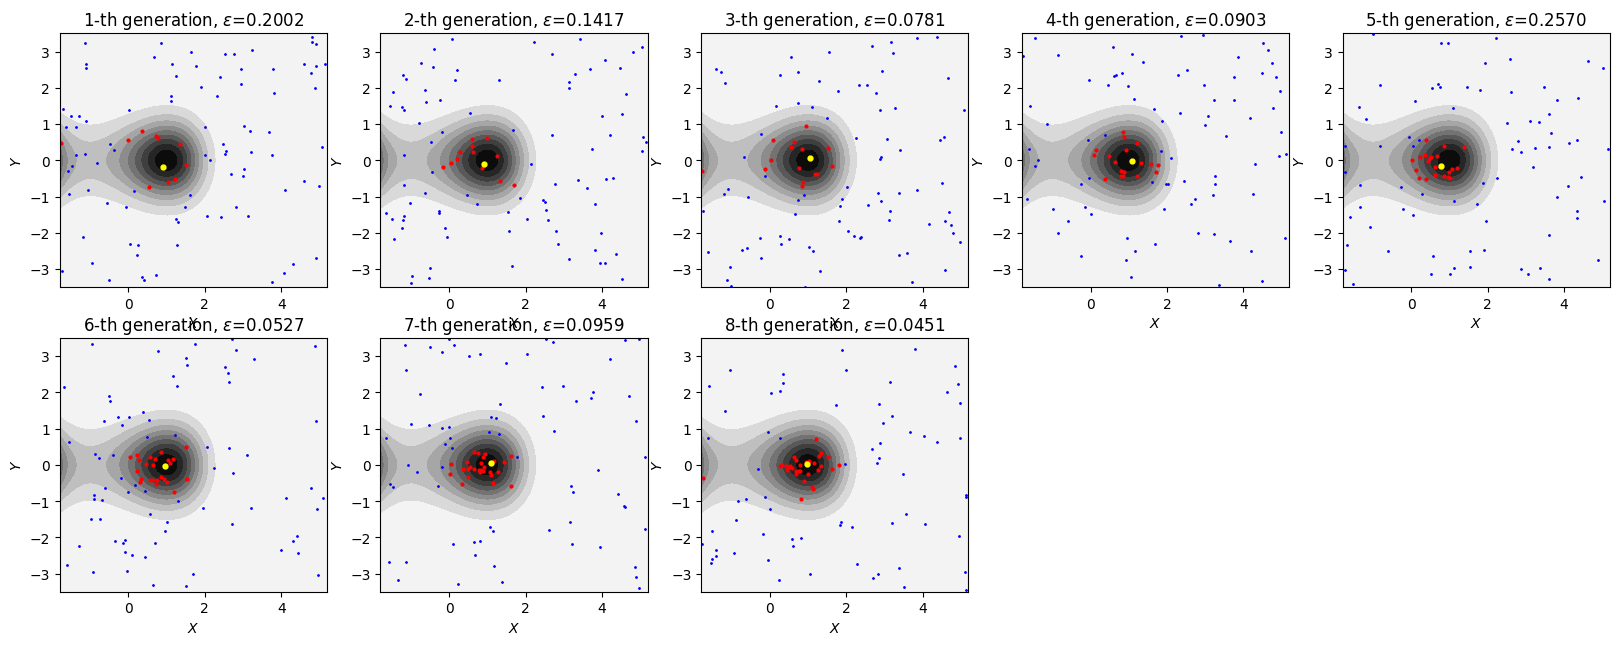

In [16]:
opt_MC_optimization(ex_function, 100, 5e-2, 100, x, y, X, Y, Z, 'yes', 'no');

It may seem that the convergence is quire slow, but this is directly related with the specified tolerance (and it is necessary for other types of more complex functions). Before moving into other functions, a group of simulations will be performed to see if there is an optimum point with the minimum number of evaluations (in order to reduce the  number of CFD simulations). 

Therefore, different combinations of initial points and tolerances will be tested one hundred times to analyze the stochastic behavior. If the simulation returns a <tt> genLim </tt> - i.e. it has not been suscessful - the results will be deprecated.

In [17]:
# create a vector with the initial points (way less than for classical Monte Carlo)
initialPointsLP = np.linspace(10,100,10)
# preallocate space for [initial points, tolerance, simulations, function_outputs]
MCopt = np.zeros((len(initialPointsLP),5,100,2)) 
# set a limit in the generations
genLim = 500

# progress bar to avoid boredom
iter_val = FloatProgress(min=0, max=np.shape(MCopt)[0]*np.shape(MCopt)[1]*np.shape(MCopt)[2])
display(iter_val)

# loop over all the initial points
for h in range(np.shape(MCopt)[0]):
    # loop over all tolerances
    for i in range(np.shape(MCopt)[1]):
        # loop certain number of simulations for statistical purposes
        for j in range(np.shape(MCopt)[2]):
            # save the data for this optimization
            MCopt[h,i,j,:] = opt_MC_optimization(ex_function, int(initialPointsLP[i]), 1*10**(1-i), genLim, x, y, X, Y, Z, 'nope', 'nope')
            # add one to the progress bar
            iter_val.value += 1

# compute and print the number of failed simulations
failedSim = sum(sum(sum(MCopt[:,:,:,0]==genLim)))
print('%i attempts in which the number of generations was reached before the tolerance' %failedSim)

FloatProgress(value=0.0, max=5000.0)

866 attempts in which the number of generations was reached before the tolerance


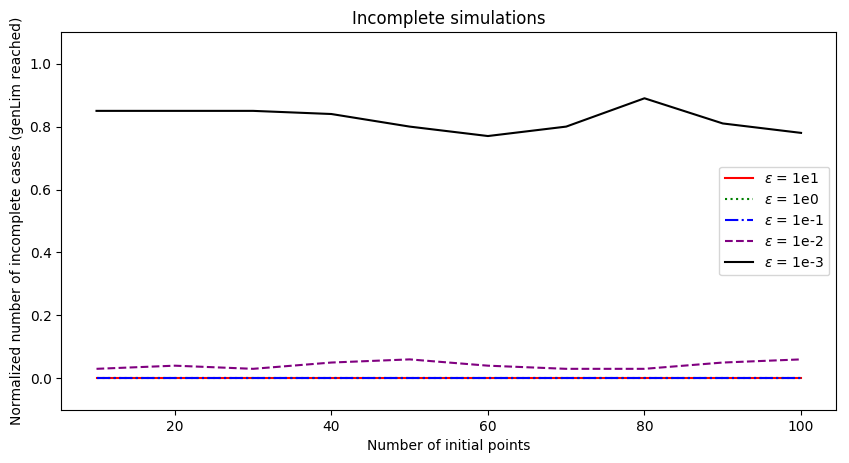

In [18]:
# plot the number of optimizations whose generation limit has been reached before the tolerance value
fig, ax1 = plt.subplots(1, figsize=((10,5)), dpi = 100)
ax1.plot(initialPointsLP, np.sum(MCopt[:,0,:,0] == genLim, axis=1)/np.shape(MCopt)[2], '-', color = 'r', label=r'$\epsilon$ = 1e1')
ax1.plot(initialPointsLP, np.sum(MCopt[:,1,:,0] == genLim, axis=1)/np.shape(MCopt)[2], ':', color = 'g', label=r'$\epsilon$ = 1e0')
ax1.plot(initialPointsLP, np.sum(MCopt[:,2,:,0] == genLim, axis=1)/np.shape(MCopt)[2], '-.', color = 'b', label=r'$\epsilon$ = 1e-1')
ax1.plot(initialPointsLP, np.sum(MCopt[:,3,:,0] == genLim, axis=1)/np.shape(MCopt)[2], '--', color = 'purple', label=r'$\epsilon$ = 1e-2')
ax1.plot(initialPointsLP, np.sum(MCopt[:,4,:,0] == genLim, axis=1)/np.shape(MCopt)[2], '-', color = 'k', label=r'$\epsilon$ = 1e-3')
ax1.set_xlabel('Number of initial points')
ax1.set_ylabel('Normalized number of incomplete cases (genLim reached)')
ax1.set_title(r'Incomplete simulations')
ax1.set_ylim([-0.1,1.1])
ax1.legend()

In [19]:
# ignoring the results that have not been suscesful
MCopt[MCopt[:,:,:,0]==genLim] = False

# preallocate space for [initial points, tolerance, (EVmean, EVstd, EVfail)]
MCopt_error = np.zeros((np.shape(MCopt)[0], np.shape(MCopt)[1], 2))

# loop over all posible initial points
for h in range(np.shape(MCopt)[0]):
    # loop over the different number of tolerances for each initial point
    for i in range(np.shape(MCopt)[1]):
        # compute the mean and standard deviation values
        MCopt_error[h,i,0] = np.mean(MCopt[h,i,MCopt[h,i,:,0]!=False,0]*initialPointsLP[h])
        MCopt_error[h,i,1] = np.std(MCopt[h,i,MCopt[h,i,:,0]!=False,0]*initialPointsLP[h])

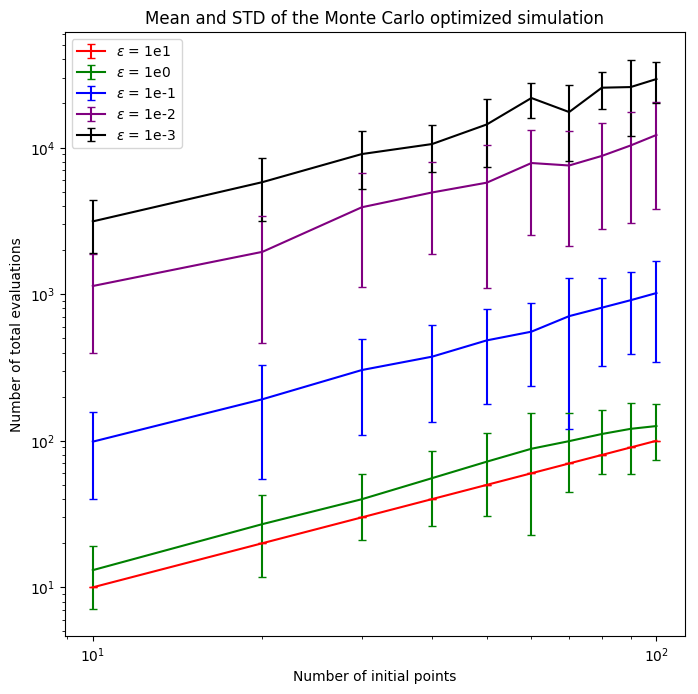

In [20]:
# plot the results of the optimized Monte Carlo simulation
fig, (ax1) = plt.subplots(1, figsize=(8,8), dpi = 100)

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.errorbar(initialPointsLP, MCopt_error[:,0,0], MCopt_error[:,0,1], color = 'r', capsize = 3, label=r'$\epsilon$ = 1e1')
ax1.errorbar(initialPointsLP, MCopt_error[:,1,0], MCopt_error[:,1,1], color = 'g', capsize = 3, label=r'$\epsilon$ = 1e0')
ax1.errorbar(initialPointsLP, MCopt_error[:,2,0], MCopt_error[:,2,1], color = 'b', capsize = 3, label=r'$\epsilon$ = 1e-1')
ax1.errorbar(initialPointsLP, MCopt_error[:,3,0], MCopt_error[:,3,1], color = 'purple', capsize = 3, label=r'$\epsilon$ = 1e-2')
ax1.errorbar(initialPointsLP, MCopt_error[:,4,0], MCopt_error[:,4,1], color = 'k', capsize = 3, label=r'$\epsilon$ = 1e-3')
ax1.set_xlabel('Number of initial points')
ax1.set_ylabel('Number of total evaluations')
ax1.set_title('Mean and STD of the Monte Carlo optimized simulation')
ax1.legend()

Although there is not a trend in the data (and every time that the code is run, results will vary), some things can be extracted from the plots. First of all, it is worth using less initial points - even using more generations to achieve tolerance error. This is valid for all cases presented. It must also be noticed that the number of incomplete simulations is fairly low (below 5% of the cases) except when tolerance is lowered too much - having that it is not possible to reach the desired precision with that limit of generations.

Let's compare the optimized Monte Carlo simulation with the classical Monte Carlo simulation. It can be compared with a fixed $\varepsilon$ (varying the number of points) or varying the error from <tt> 1e0 </tt> to <tt> 1e-4 </tt> (and fixing the number of initial poitns to the best value)

In [21]:
# initial points will be always 10, as said it gives the best results
# create a list for the errors
allowableError = np.logspace(0.5,-2,50)
# preallocate space for [errors, simulations, function_outputs]
MCvariableError = np.zeros((len(allowableError),20,2)) 
# increase it to promote that all optimizations end
genLim = 1000

# create the progress bar
iter_val = FloatProgress(min=0, max=np.shape(MCvariableError)[0]*np.shape(MCvariableError)[1])
display(iter_val)

# loop over the allowable errors
for h in range(np.shape(MCvariableError)[0]):
    # for different times to get some statistical relevance
    for i in range(np.shape(MCvariableError)[1]):
        # store the data
        MCvariableError[h,i,:] = opt_MC_optimization(ex_function, 10, allowableError[h], genLim, x, y, X, Y, Z, 'nope', 'nope')
        # and increase the progress bar by one
        iter_val.value += 1

# hopefully this should be zero
print('%i attempts in which the number of generations was reached before the tolerance' %sum(sum(sum(MCopt[:,:,:,0]==genLim))))

FloatProgress(value=0.0, max=1000.0)

0 attempts in which the number of generations was reached before the tolerance


In [22]:
# just in case any optimization have gone over generation limit
MCvariableError[MCvariableError[:,:,0] == genLim] = False

# preallocate space for [initial points, tolerance, (EVmean, EVstd)]
varEmc_error = np.zeros((np.shape(MCvariableError)[0], 2))

# loop over all the desired errors
for h in range(np.shape(MCvariableError)[0]):
    # and compute the mean and standard deviation
    varEmc_error[h,0] = np.mean(MCvariableError[h,MCvariableError[h,:,0]!=False,0]*10)
    varEmc_error[h,1] = np.std(MCvariableError[h,MCvariableError[h,:,0]!=False,0]*10)

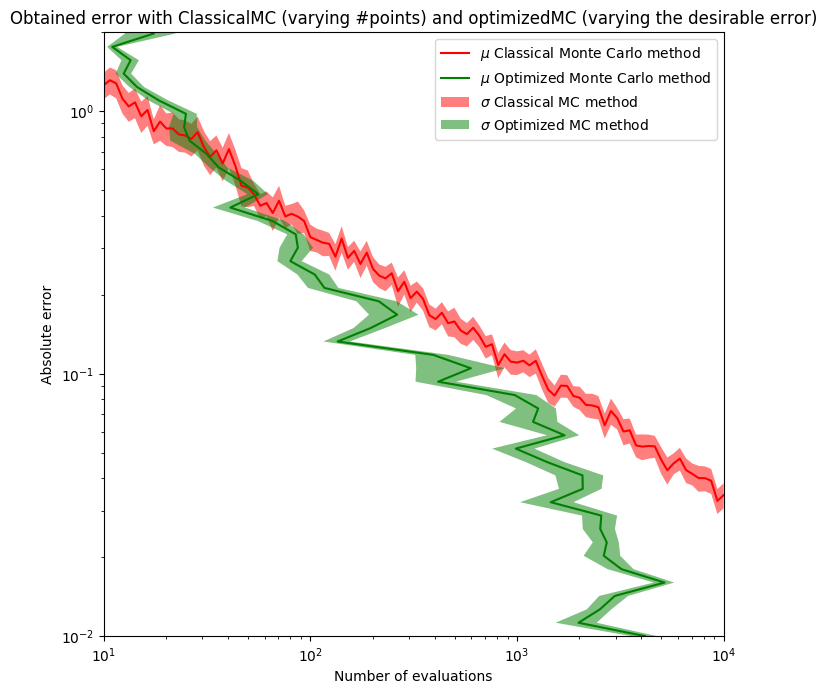

In [23]:
# plot the obtained results
fig, (ax1) = plt.subplots(1, figsize=((8,8)), dpi = 100)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.plot(initialPointsClassicalMC, cMCopt_error[:,0], color = 'r', label=r'$\mu$ Classical Monte Carlo method')
ax1.fill_between(initialPointsClassicalMC, cMCopt_error[:,0]+0.2*cMCopt_error[:,1], cMCopt_error[:,0]-0.2*cMCopt_error[:,1], facecolor='red', alpha=0.5, label = r'$\sigma$ Classical MC method')
ax1.plot(varEmc_error[:,0], allowableError, color = 'g', label=r'$\mu$ Optimized Monte Carlo method')
ax1.fill_betweenx(allowableError[:], varEmc_error[:,0]+0.2*varEmc_error[:,1], varEmc_error[:,0]-0.2*varEmc_error[:,1], facecolor='g', alpha=0.5, label = r'$\sigma$ Optimized MC method')
ax1.set_xlabel('Number of evaluations')
ax1.set_ylabel('Absolute error')
ax1.set_title('Obtained error with ClassicalMC (varying #points) and optimizedMC (varying the desirable error)')
ax1.set_ylim([1e-2,2])
ax1.set_xlim([1e1,1e4])
ax1.legend()

From $\sim 50$ evaluations and so on it it better the optimized Monte Carrlo Method given that for the same number of evaluations, the error is smaller. 

# 4. Declarations to test functions for optimization

To test the performance under a wider variety of functions, one function must be created to confront both methods.

In [24]:
def function_testing(function, noPoints, tol, genLim, searchX, searchY, desiredVal, plotOp, savePlot):
    '''Function created to perform the clash between MC and optMC
    INPUT:
        function: function to be evaluated
        noPoints: number of points of each generation in the optimized MC method 
        (classical MC points are automatically computed for a fair comparison)
        tol: desired tolerance
        genLim: limit in generations
        searchX: array with the range of the search space in the X direction
        searchX: array with the range of the search space in the Y direction
        desiredVal: array with the location of the maximum 
        plotOp: flag to select if the figure should be plotted or not 
        savePlot: flag to save the figure or not

    OUTPUT:
        The output is the plot with the results obtained after the simulation
        gen: number of generations of the optimized Monte Carlo method
        error: error of the optimized Monte Carlo mehtod
        errorC: error of the classical Monte Carlo method
    '''  
    
    # plotting matrix computations
    x = np.linspace(searchX[0], searchX[1], 100)
    y = np.linspace(searchY[0], searchY[1], 100)
    X, Y = np.meshgrid(x,y)
    Z = function(X, Y)
    
    
    #########################################################################################
    #                             OPTIMIZED MONTE CARLO METHOD                              #
    #########################################################################################
    
    # define the genetion counter as one    
    gen = 1

    # random distributed grid with the specified number of points
    xi = np.random.uniform(x[0], x[-1], noPoints)
    yi = np.random.uniform(y[0], y[-1], noPoints)
    
    # evaluate the function
    zi = function(xi,yi)
    
    # take the best specimenes from the sample
    # the number of points to choose is described by:
    selectPoints = int(round((noPoints/2.5)*(np.tanh(gen/10-1)+1)))
    
    # if only one point is choosen, mean and convariance are unfeasible
    if selectPoints <= 1: 
        selectPoints = 2 
        
    # points are ordered and the 'selectPoints' maximum values are choosen
    xbest = xi[np.argsort(zi)[-selectPoints:]]
    ybest = yi[np.argsort(zi)[-selectPoints:]]

    # compute the mean and covariance of the best selected data
    mean = np.array([np.mean(xbest), np.mean(ybest)])
    cov = np.cov(xbest,ybest)
    
    # with the mean and covariance values, run a multivariate_normal distribution
    normal = np.random.multivariate_normal(mean, cov, selectPoints)

    # compute the error to establish a stop criteria
    error = np.sqrt((xi[np.argsort(zi)[-1:]]-desiredVal[0])**2+(yi[np.argsort(zi)[-1:]]-desiredVal[1])**2)   

    # while the number of generations or the tolerance is not reached
    while error > tol and gen < genLim:
        # advance the generation counter
        gen += 1
    
        # combine the random distributed with the normal distributed points
        xi = np.concatenate([np.random.uniform(x[0], x[-1], noPoints-selectPoints), normal[:,0]])
        yi = np.concatenate([np.random.uniform(y[0], y[-1], noPoints-selectPoints), normal[:,1]])
        
        # restrict the search boundaries to the specified values in vectors x and y
        xi[xi < x[0]] = x[0]
        xi[xi > x[-1]] = x[-1]
        yi[yi < y[0]] = y[0]
        yi[yi > y[-1]] = y[-1]
    
        # evaluate the function
        zi = function(xi,yi)

        # take the best specimenes from the sample
        # the number of points to choose is described by:
        selectPoints = int(round((noPoints/2.5)*(np.tanh(gen/10-1)+1)))

        # if only one point is choosen, mean and convariance are unfeasible
        if selectPoints <= 1: 
            selectPoints = 2 

        # points are ordered and the 'selectPoints' maximum values are choosen
        xbest = xi[np.argsort(zi)[-selectPoints:]]
        ybest = yi[np.argsort(zi)[-selectPoints:]]

        # compute the mean and covariance of the best selected data
        mean = np.array([np.mean(xbest), np.mean(ybest)])
        cov = np.cov(xbest,ybest)

        # compute the mean and covariance of the best selected data
        normal = np.random.multivariate_normal(mean, cov, selectPoints)

        # compute the error to establish a stop criteria
        error = np.sqrt((xi[np.argsort(zi)[-1:]]-desiredVal[0])**2+(yi[np.argsort(zi)[-1:]]-desiredVal[1])**2)   

    #########################################################################################
    #                             CLASSICAL MONTE CARLO METHOD                              #
    #########################################################################################
    # the letter C in all variables stand for Classical
    
    # define the number of points as to be the same as the total evaluations of the optimized 
    noPointsC = gen*noPoints
    
    # random distributed grid
    xiC = np.random.uniform(x[0], x[-1], noPointsC)
    yiC = np.random.uniform(y[0], y[-1], noPointsC)
    
    # evaluation of the function
    ziC = function(xiC,yiC)

    # the maximum point is choosen as the better one to perform the error calculation
    errorC = np.sqrt((xiC[ziC.argmax()]-desiredVal[0])**2+(yiC[ziC.argmax()]-desiredVal[1])**2)
    
    
    #########################################################################################
    #                                        PLOTTING                                       #
    ######################################################################################### 
       
    # plotting section of the function if desired   
    if plotOp == 'y' or plotOp == 'yes':
        levels = 50
        selectPoints = int(0.1*noPoints)
        
        fig = plt.figure(figsize=(24,24))
        ax1 = fig.add_subplot(2, 2, 1, projection='3d')
        ax1.plot_surface(X, Y, Z, rstride = 1, cstride = 1, cmap = cm.viridis, linewidth = 0, antialiased = False)
        ax1.set_xlabel('$X$')
        ax1.set_ylabel('$Y$')
        ax1.set_zlabel('$Z$')
        ax1.set_title('3D view')
        
        ax2 = fig.add_subplot(2, 2, 2)
        ax2.contourf(X, Y, Z, levels, cmap = cm.viridis, antialiased = False)
        ax2.contour(X, Y, Z, int(levels/5) if levels>10 else 10, colors='k')
        ax2.set_xlabel('$X$')
        ax2.set_ylabel('$Y$')
        ax2.set_title('Contour Plot')
        
        ax3 = fig.add_subplot(2, 2, 3)
        ax3.contourf(X, Y, Z, 10, cmap = cm.binary_r)
        ax3.plot(xiC[np.argsort(ziC)[-noPoints:]],yiC[np.argsort(ziC)[-noPoints:]],'b.',markersize = 7)
        ax3.plot(xiC[np.argsort(ziC)[-selectPoints:]],yiC[np.argsort(ziC)[-selectPoints:]],'b.',markersize = 10)
        ax3.plot(xiC[ziC.argmax()],yiC[ziC.argmax()],'.', color='yellow', markersize = 14)
        ax3.set_xlabel('$X$')
        ax3.set_ylabel('$Y$')
        ax3.set_xlim(x[0], x[-1])
        ax3.set_ylim(y[0], y[-1])
        ax3.set_title('Monte Carlo simulation, $\epsilon$=%.4f' %(errorC)) 
       
        ax4 = fig.add_subplot(2, 2, 4)
        ax4.contourf(X, Y, Z, 10, cmap = cm.binary_r)
        ax4.plot(xi,yi,'b.',markersize = 7)
        ax4.plot(xi[np.argsort(zi)[-selectPoints:]],yi[np.argsort(zi)[-selectPoints:]],'r.',markersize=10)
        ax4.plot(xi[np.argsort(zi)[-1:]],yi[np.argsort(zi)[-1:]],'.',color='yellow',markersize = 14)
        ax4.set_xlabel('$X$')
        ax4.set_ylabel('$Y$')
        ax4.set_xlim(x[0], x[-1])
        ax4.set_ylim(y[0], y[-1])
        ax4.set_title('Final step optimized Monte Carlo simulation, gen = %i, $\epsilon$=%.4f' %(gen, error)) 
       
    # save the figure with the name of the function if desired
    if savePlot == 'y' or savePlot == 'yes':
        plt.savefig('%s.png' %function.__name__, bbox_inches = 'tight', dpi=200)
        
    return gen, error, errorC

# 5. Functions testing (more info [here](https://en.wikipedia.org/wiki/Ackley_function))

The code has been developed to find maximums. Given that the big majority of functions are created to minimize them adding a negative sign will make that the extrema of the function goes from a minimum to a maximum.

### 5.1 Easom function

$$
f(x,y) = -\cos(x)\cos(y)\exp\left( -\left( \left( x-\pi\right)^2+ \left( y- \pi\right)^2 \right) \right)
$$

In [25]:
def easom(x,y):
    #Code created to obtain the maximum so the global sign is positive
    return np.cos(x)*np.cos(y)*np.exp(-((x-np.pi)**2+(y-np.pi)**2))

(1000, array([5.60074701]), 0.8031795077842245)

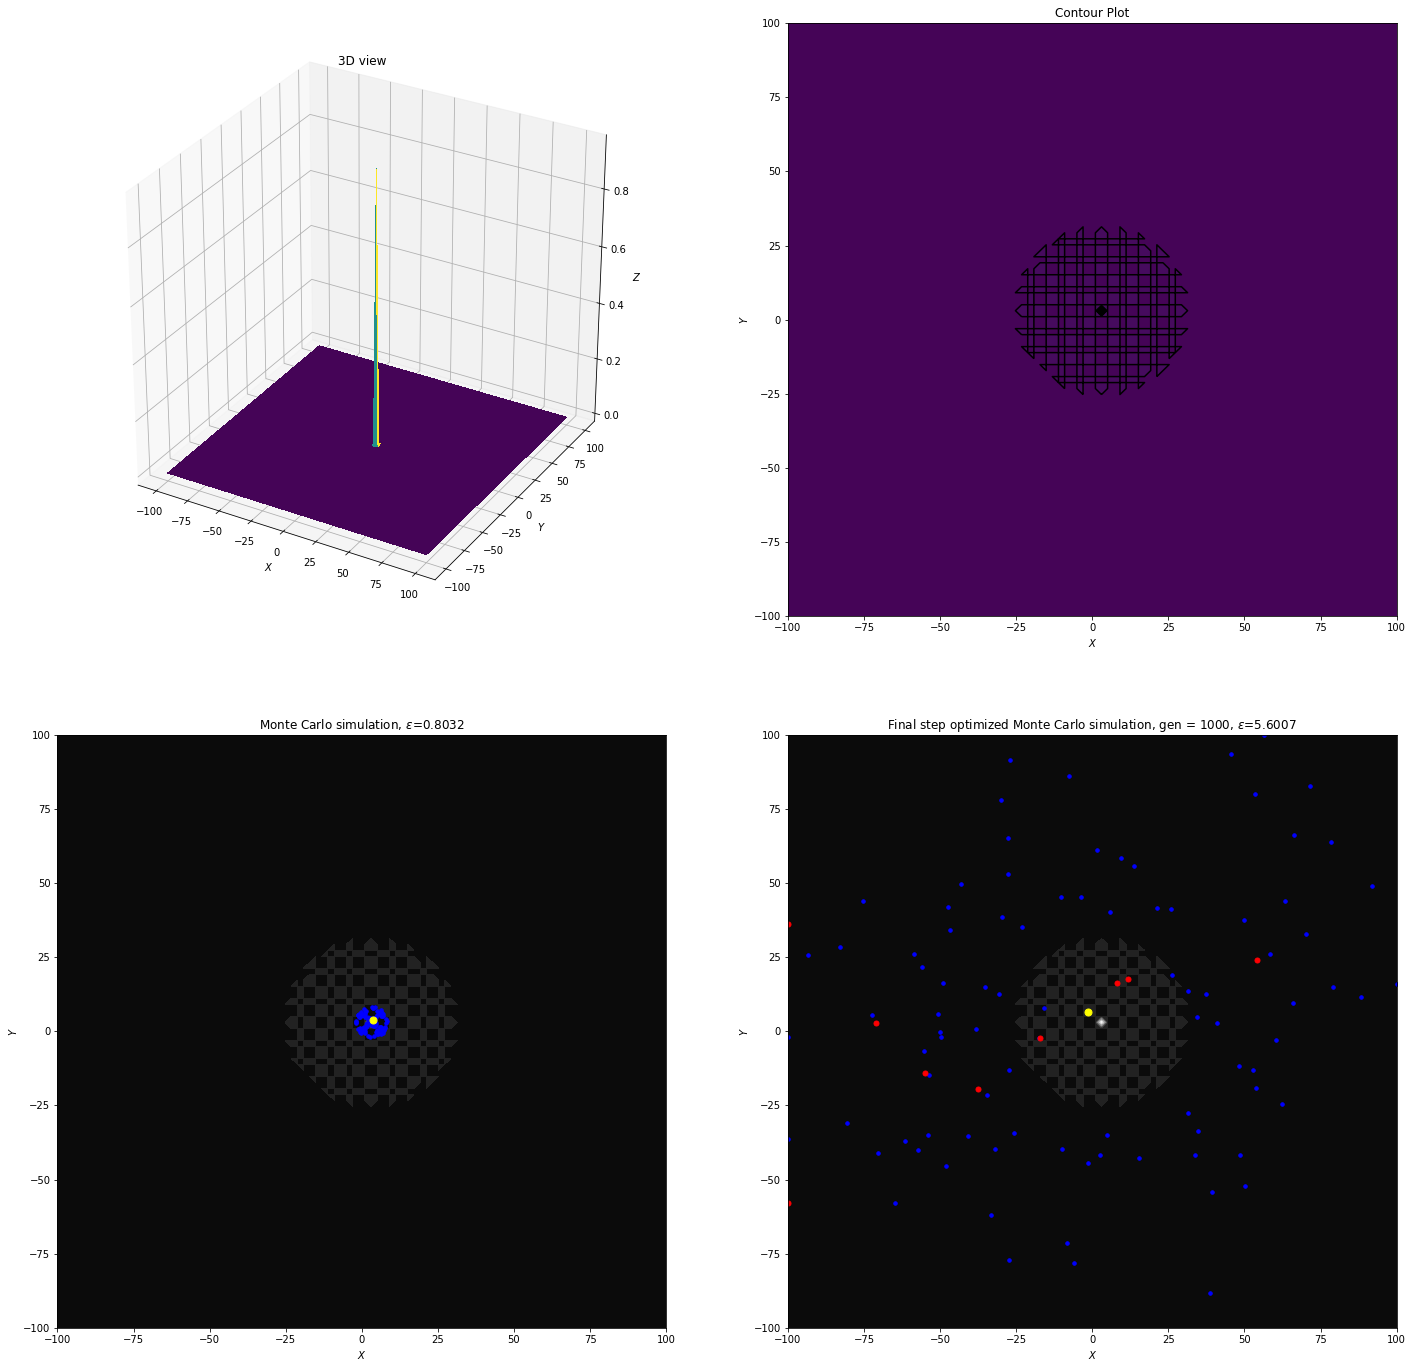

In [26]:
function_testing(easom, 100, 1e-2, 1000, [-100, 100], [-100, 100], [np.pi,np.pi], 'y', 'n')

(1000, array([3.41508575]), 0.024283750430189245)

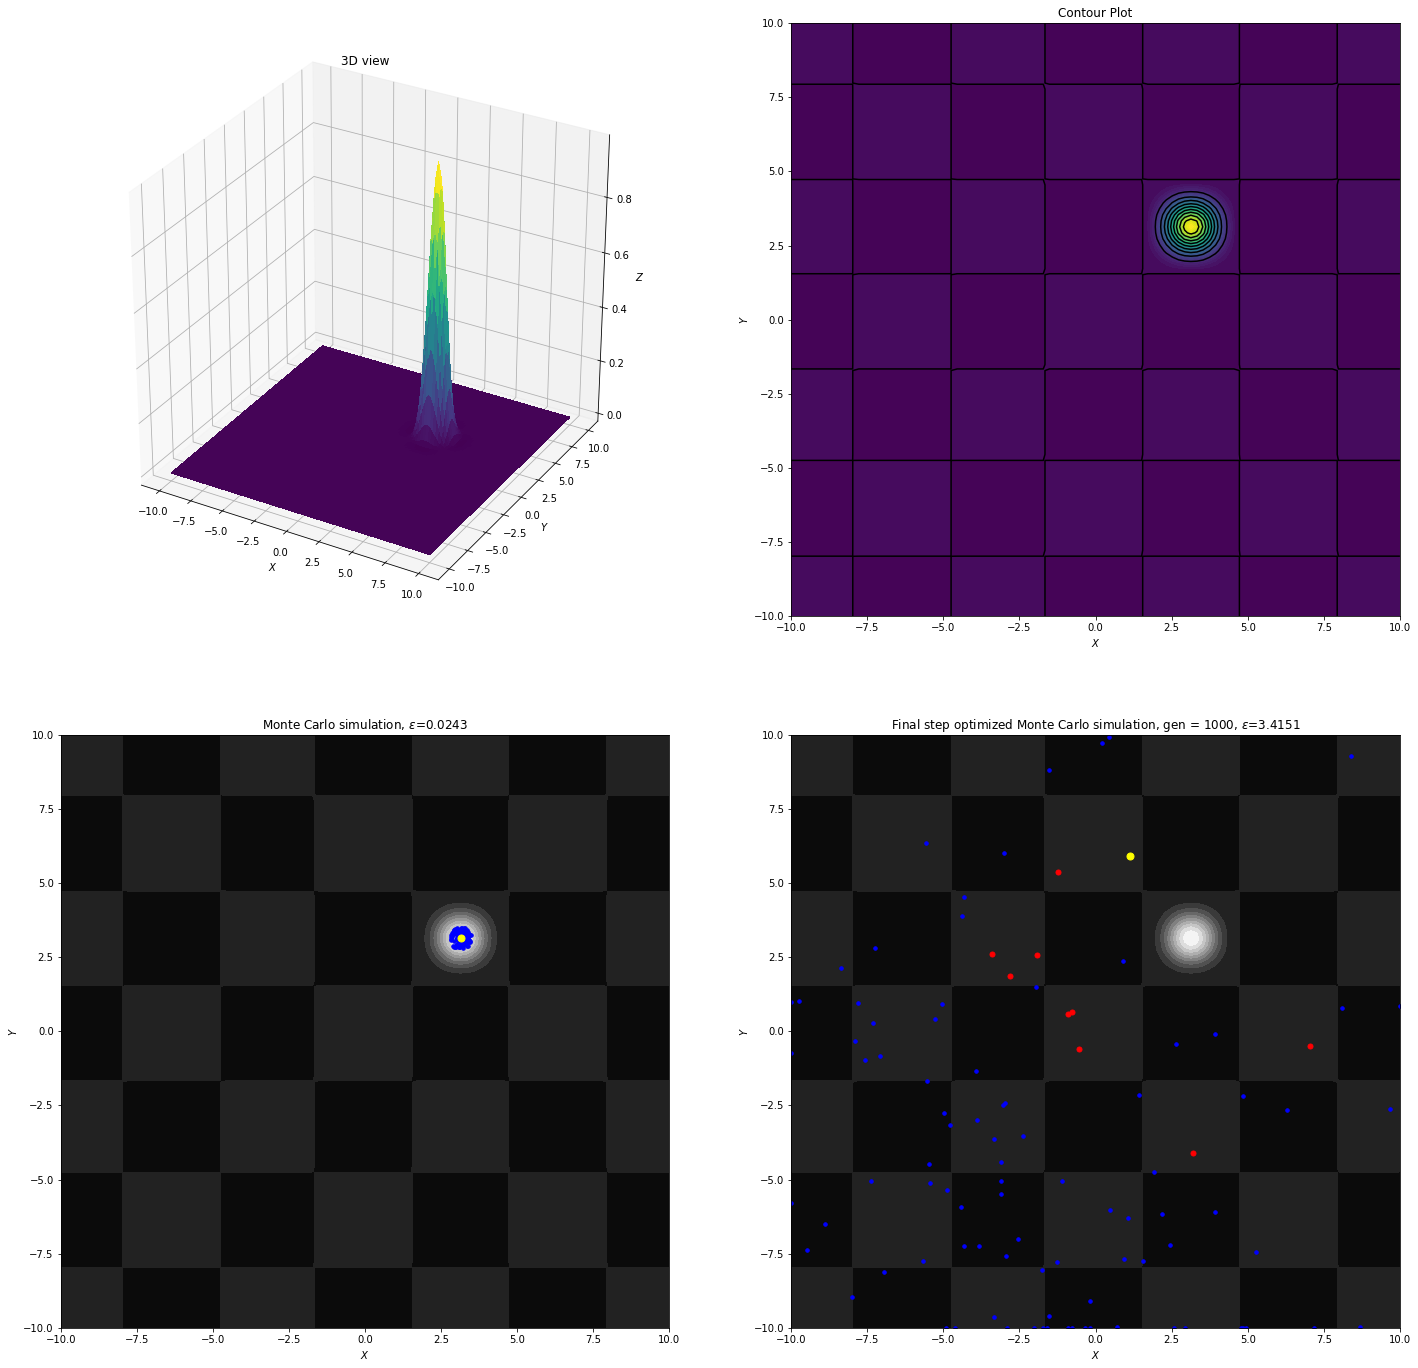

In [27]:
function_testing(easom, 100, 1e-2, 1000, [-10, 10], [-10, 10], [np.pi,np.pi], 'y', 'n')

### 5.2 Schaffer function N.2

$$
f(x,y) = 0.5+\dfrac{\sin^2(x^2-y^2)-0.5}{\left[ 1+0.001(x^2+y^2) \right]^2}
$$

In [28]:
def schaffer(x,y):
    #Code created to obtain the maximum so the first minus is used
    return -(0.5+(np.sin(x**2-y**2)**2-0.5)/(1+0.001*(x**2+y**2))**2)

(1000, array([9.87245018]), 0.5645871098317482)

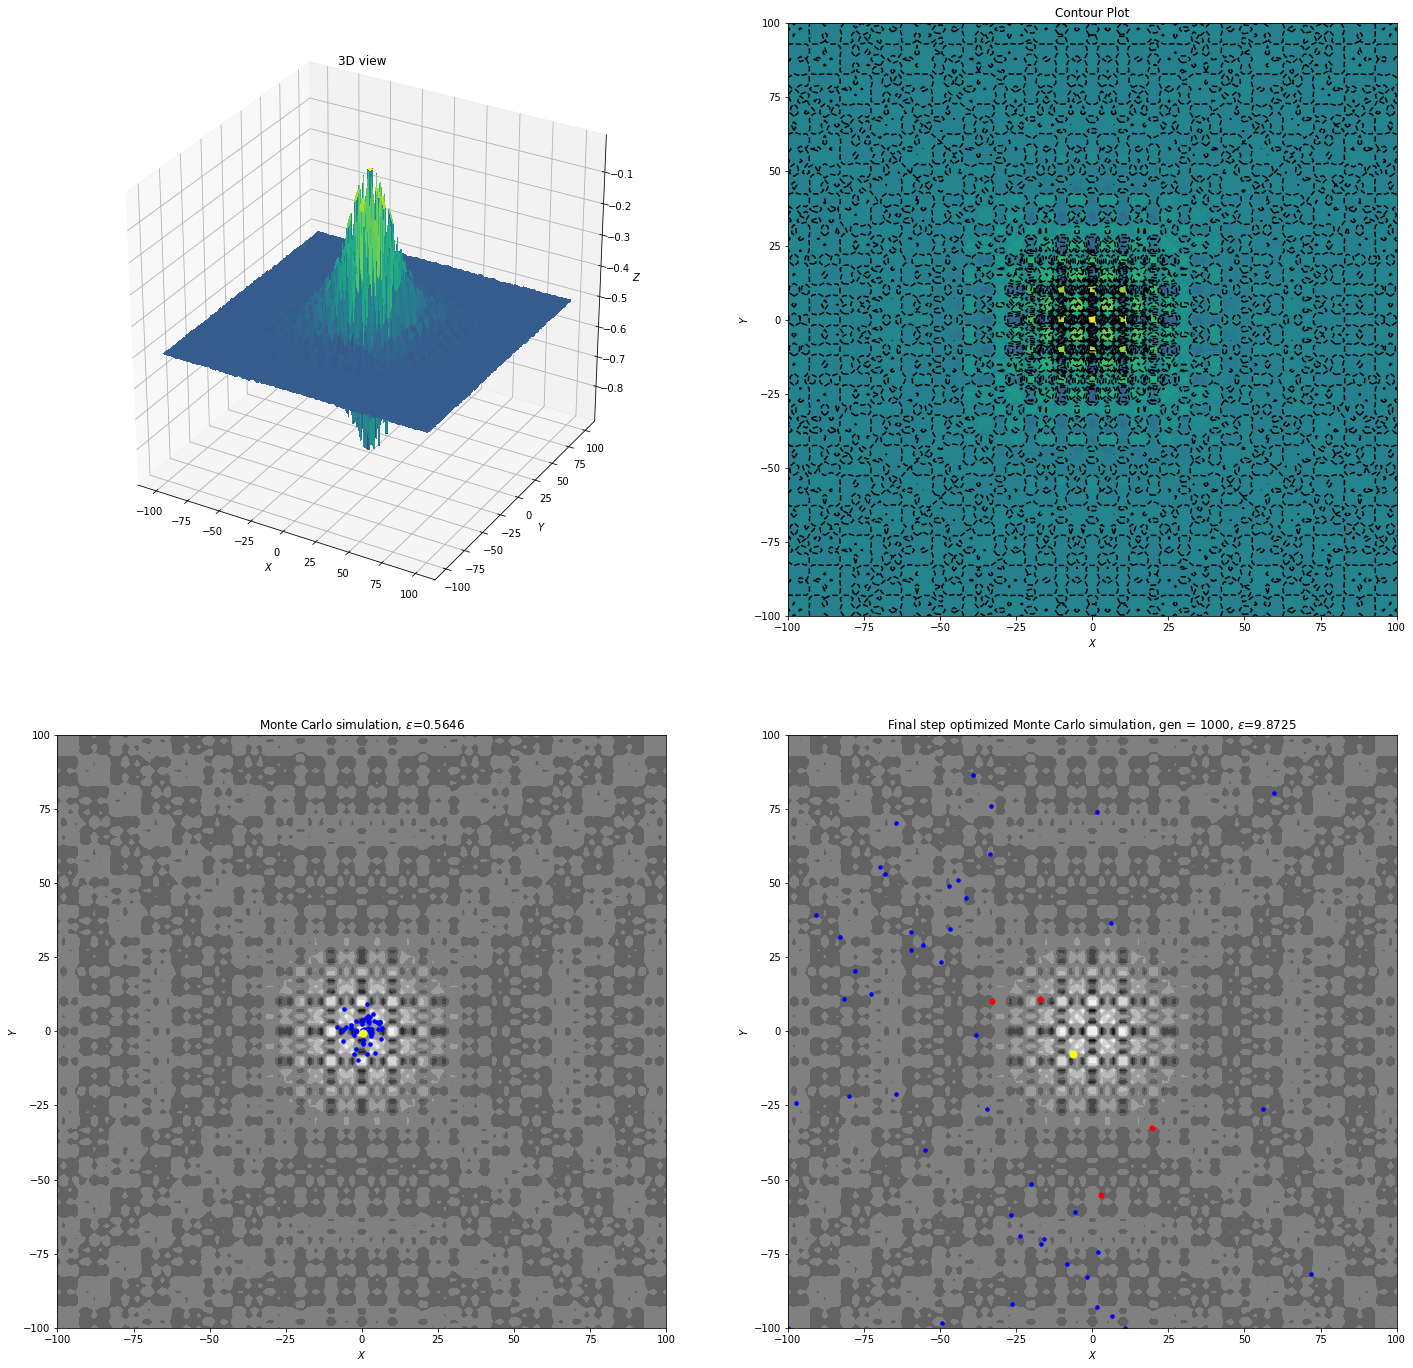

In [29]:
function_testing(schaffer, 50, 1e-2, 1000, [-100, 100], [-100, 100], [0,0], 'y', 'n')

(1000, array([7.57742947]), 0.03305288957304027)

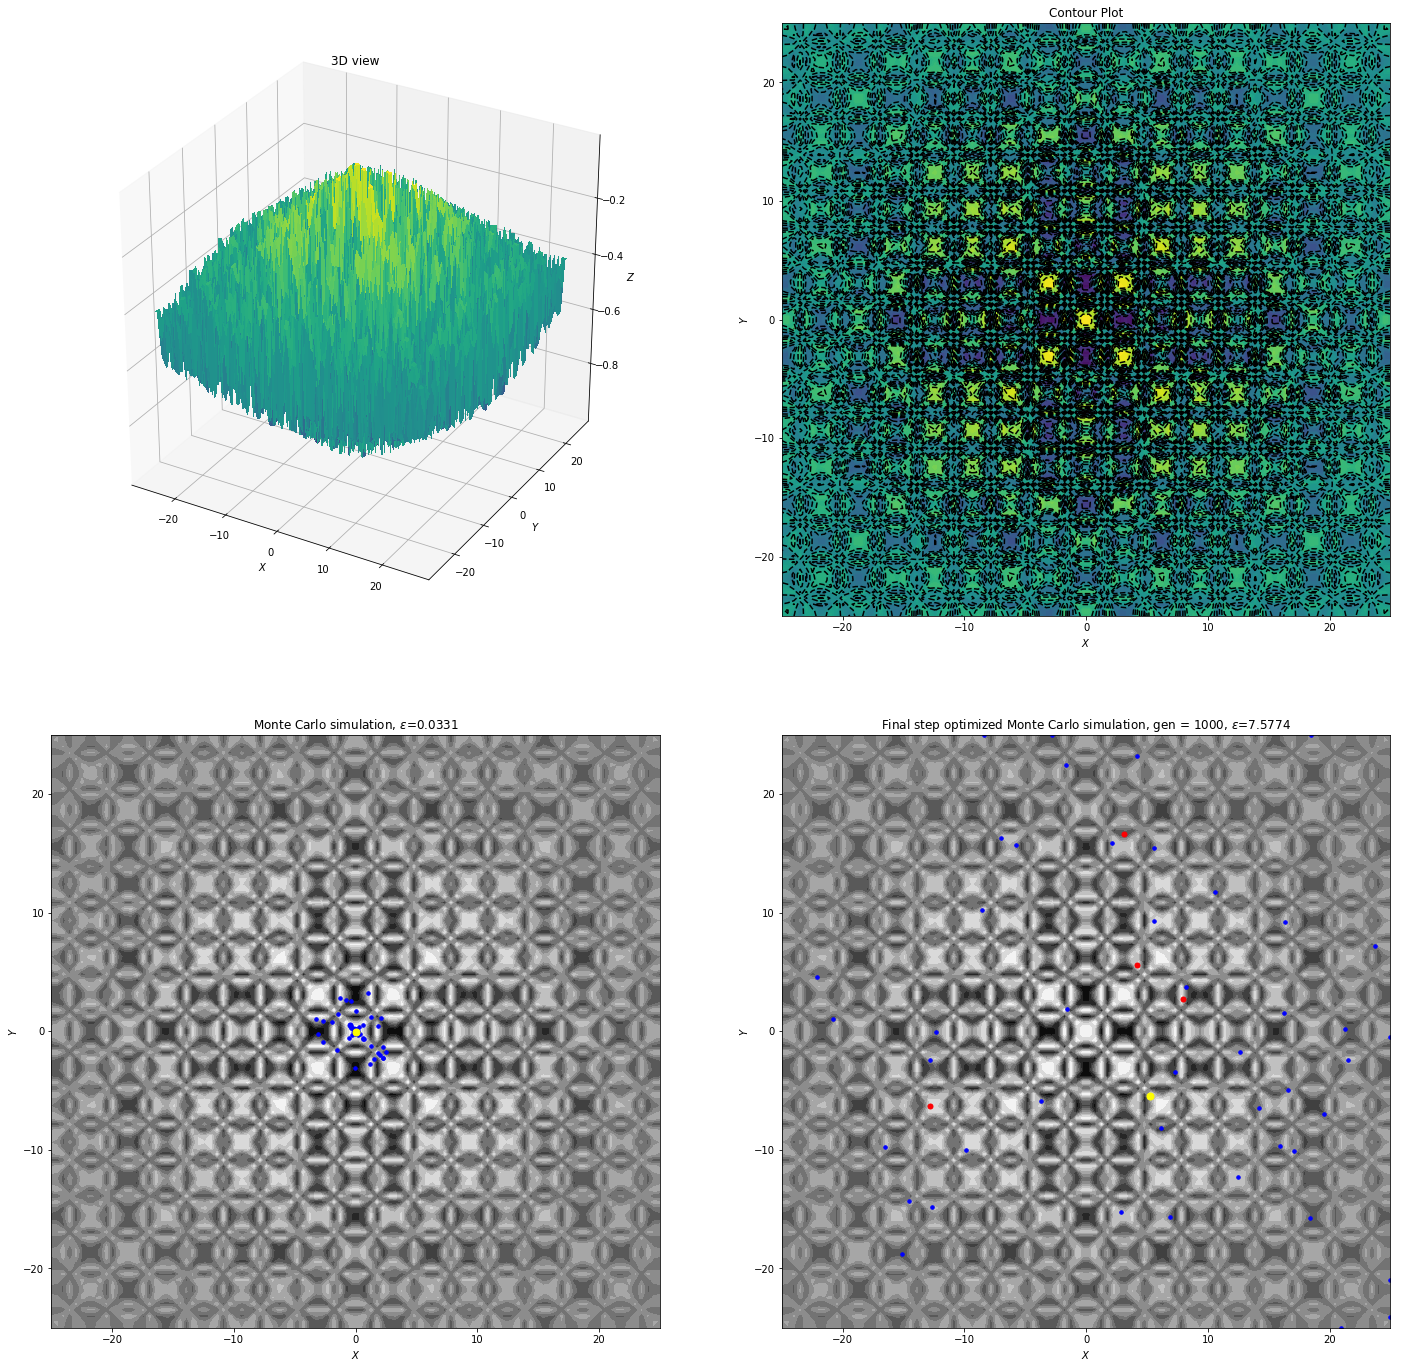

In [30]:
function_testing(schaffer, 50, 1e-2, 1000, [-25, 25], [-25, 25], [0,0], 'y', 'n')

### 5.3 Eggholder function

$$
f(x,y) = -(y+47)\sin\sqrt{\left| \dfrac{x}{2} +(y+47)\right|} - x \sin\sqrt{\left| x-(y+47) \right|}
$$

In [31]:
def eggholder(x,y):
    #Code created to obtain the maximum so the minus are replaced by additions
    return (y+47)*np.sin(np.sqrt(np.abs(x/2+(y+47))))+x*np.sin(np.sqrt(np.abs(x-(y+47))))

(1000, array([1204.10886399]), 44.705493232715845)

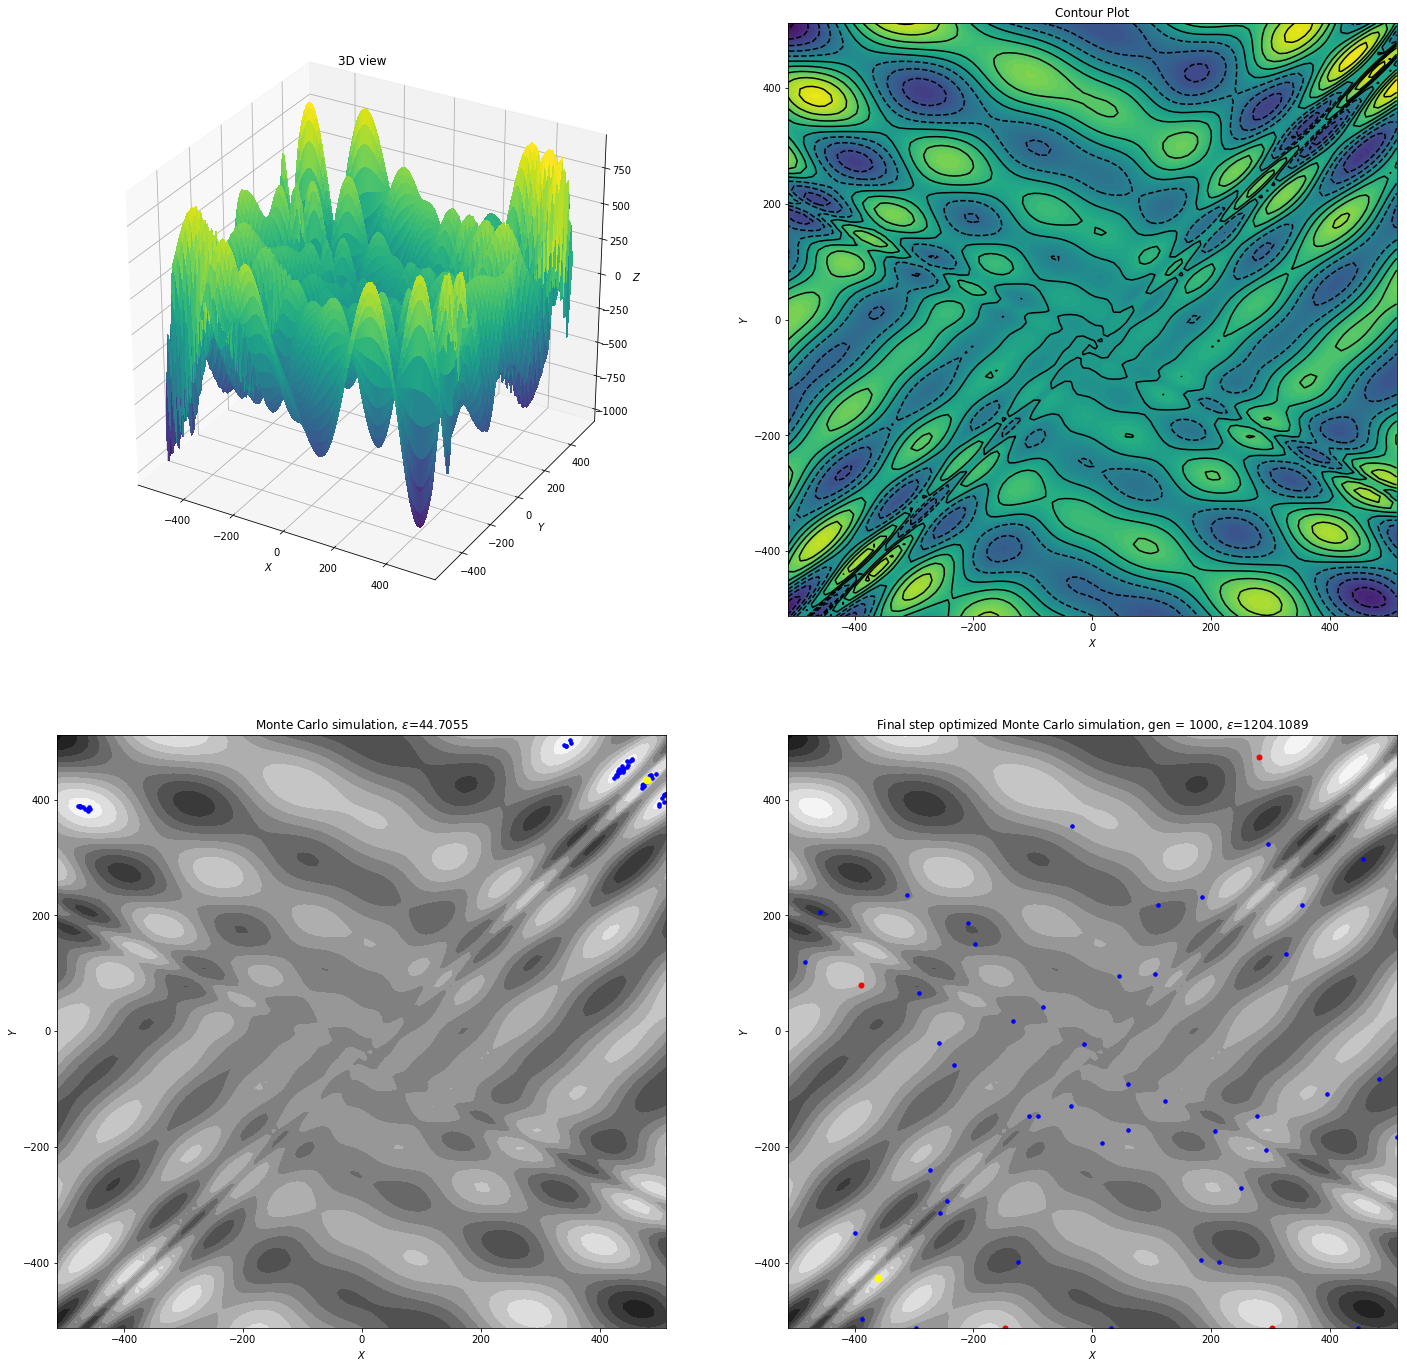

In [32]:
function_testing(eggholder, 50, 1e-2, 1000, [-512, 512], [-512, 512], [512,404.2319], 'y', 'n')

(1000, array([255.02681673]), 2.217988007692523)

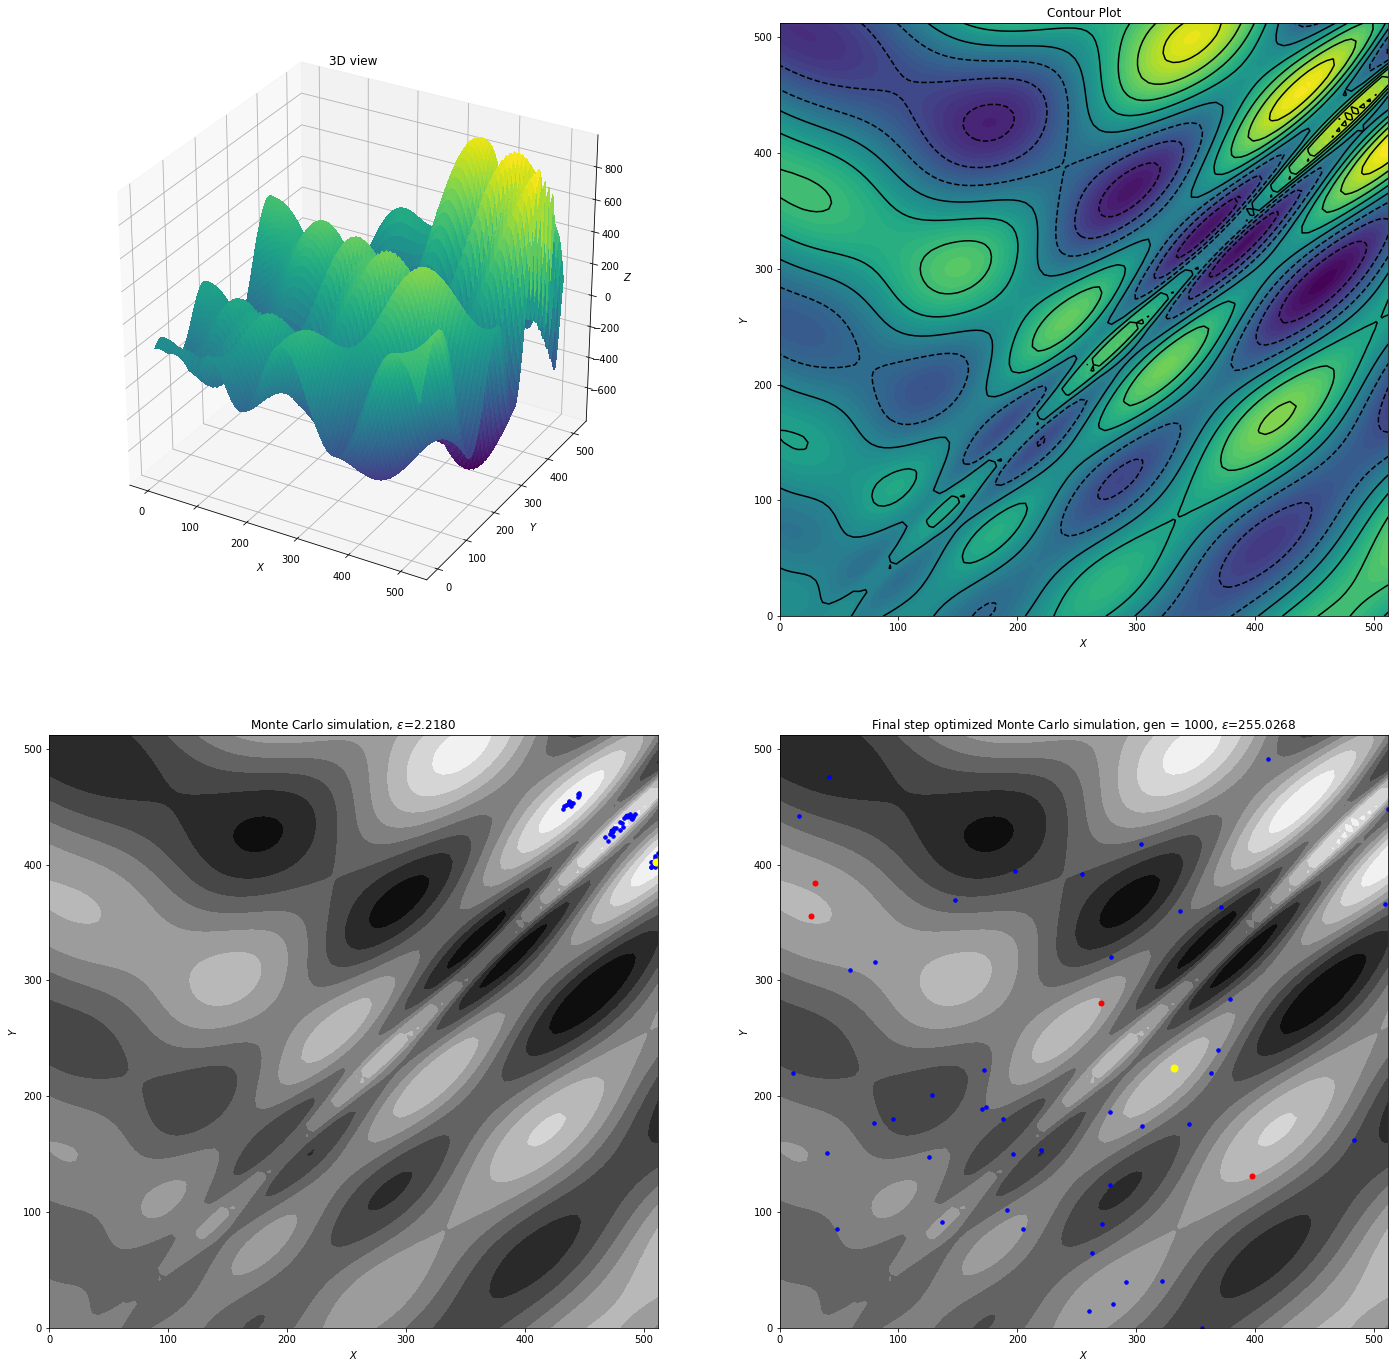

In [33]:
function_testing(eggholder, 50, 1e-2, 1000, [0, 512], [0, 512], [512,404.2319], 'y', 'n')

### 5.4 Ackley function 

$$
f(x,y) = -20\exp \left[ -0.2 \sqrt{0.5(x^2+y^2)} \right] - \exp\left[ 0.5 (\cos 2\pi x+\cos 2\pi y \right] +e +20
$$

In [34]:
def ackley(x,y):
    #Code created to obtain the maximum so the first minus is used
    return -(-20*np.exp(-0.2*np.sqrt(0.5*(x**2+y**2)))-np.exp(0.5*(np.cos(2*np.pi*x)+np.cos(2*np.pi*y)))+np.exp(1)+20)

(135, array([0.0056444]), 0.03250350135252531)

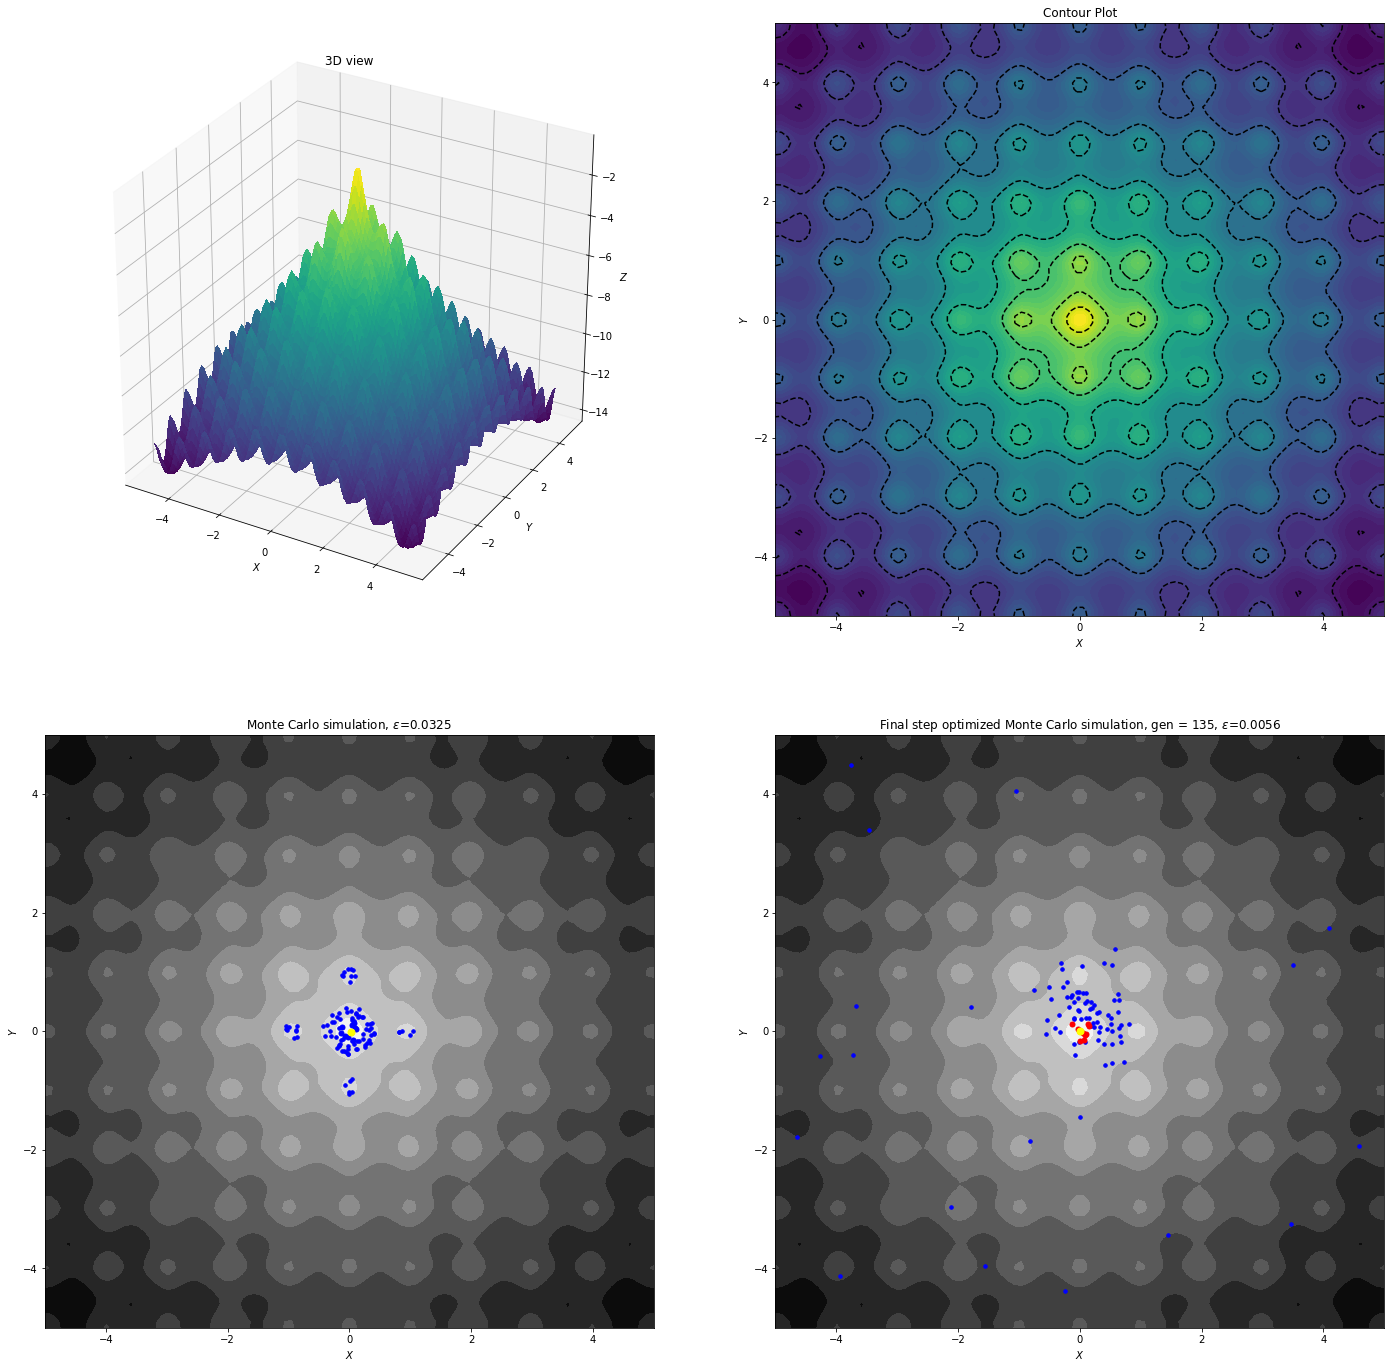

In [35]:
function_testing(ackley, 100, 1e-2, 1000, [-5, 5], [-5, 5], [0,0], 'y', 'n')

### 5.5 Beale function

$$
f(x,y) = (1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2
$$

In [36]:
def beale(x,y):
    #Code created to obtain the maximum so the first minus is used
    return -((1.5-x+x*y)**2+(2.25-x+x*y**2)**2+(2.625-x+x*y**3)**2)

(262, array([0.00725024]), 0.04953287098205982)

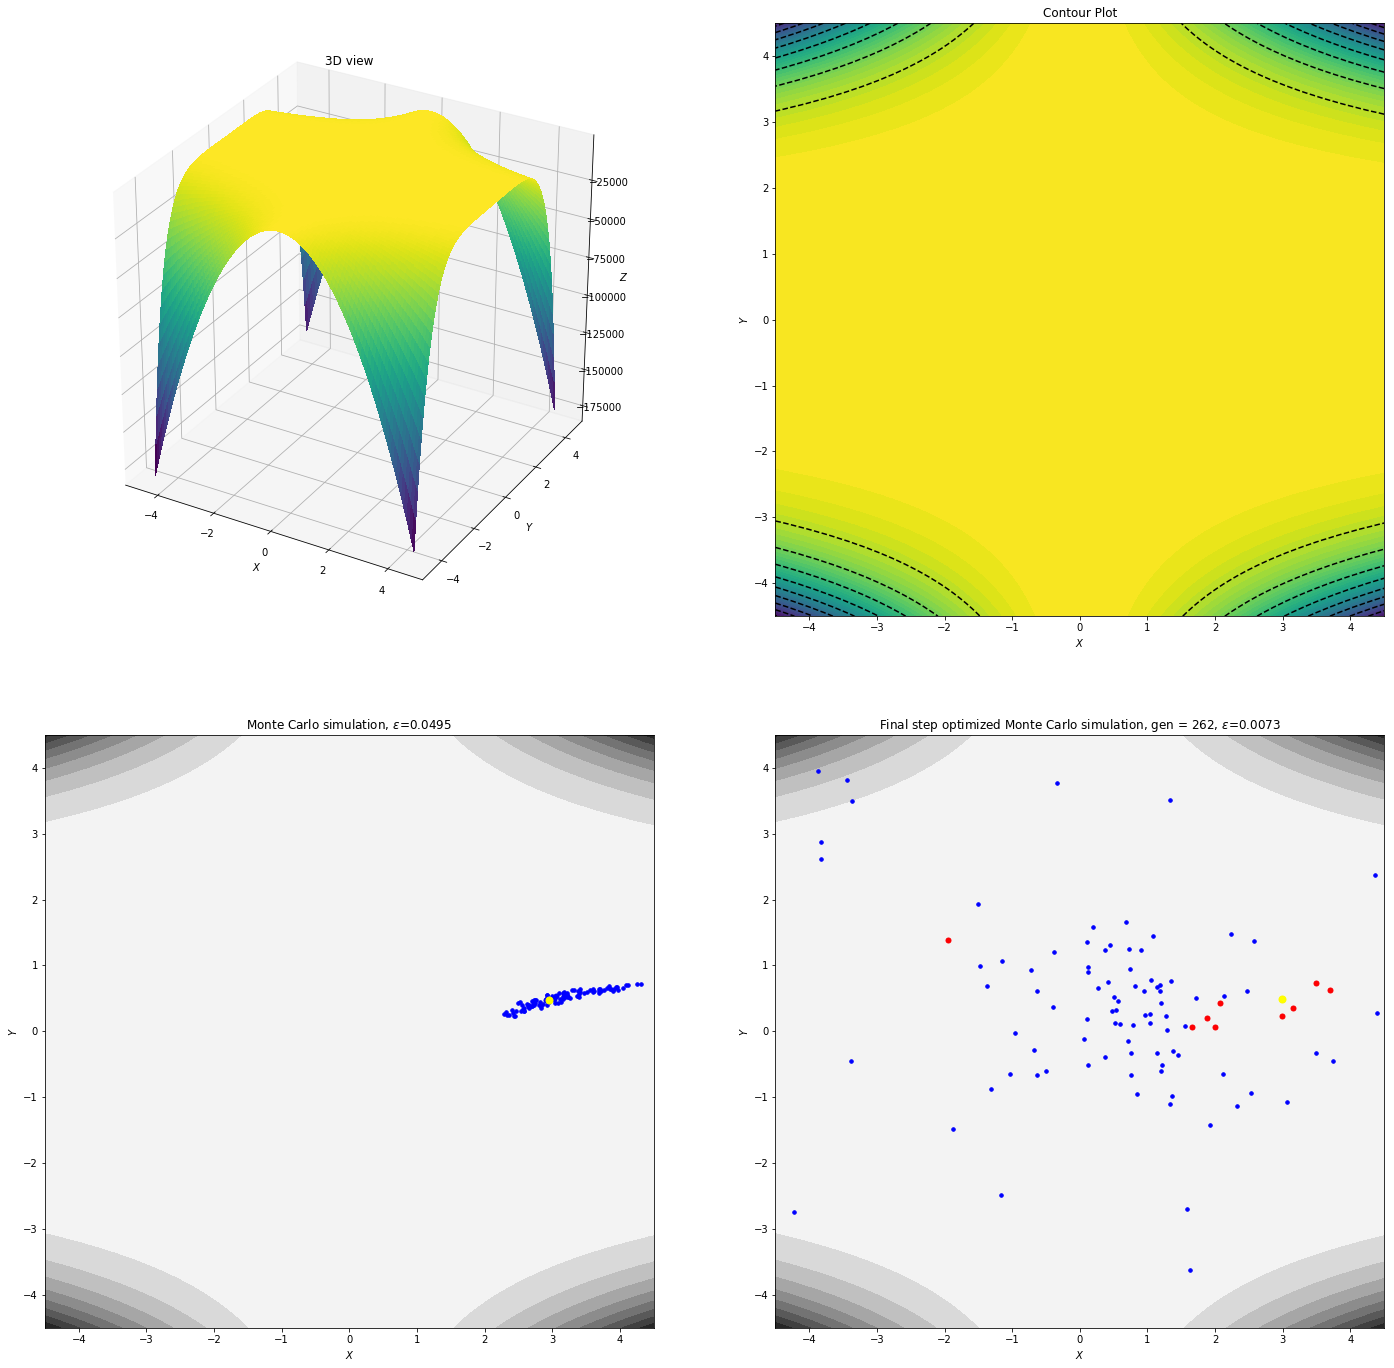

In [37]:
function_testing(beale, 100, 1e-2, 1000, [-4.5, 4.5], [-4.5, 4.5], [3, 0.5], 'y', 'n')

### 5.6 Lévi function N.13

$$
f(x,y) = \sin^23\pi x+(x-1)^2(1+\sin^23\pi y) + (y-1)^2(1+\sin^2 2\pi y)
$$

In [38]:
def levi(x,y):
    #Code created to obtain the maximum so the first minus is used
    return -(np.sin(3*np.pi*x)**2+(x-1)**2*(1+np.sin(3*np.pi*y)**2)+(y-1)**2*(1+np.sin(2*np.pi*y)**2))

(52, array([0.00660606]), 0.04220388783489158)

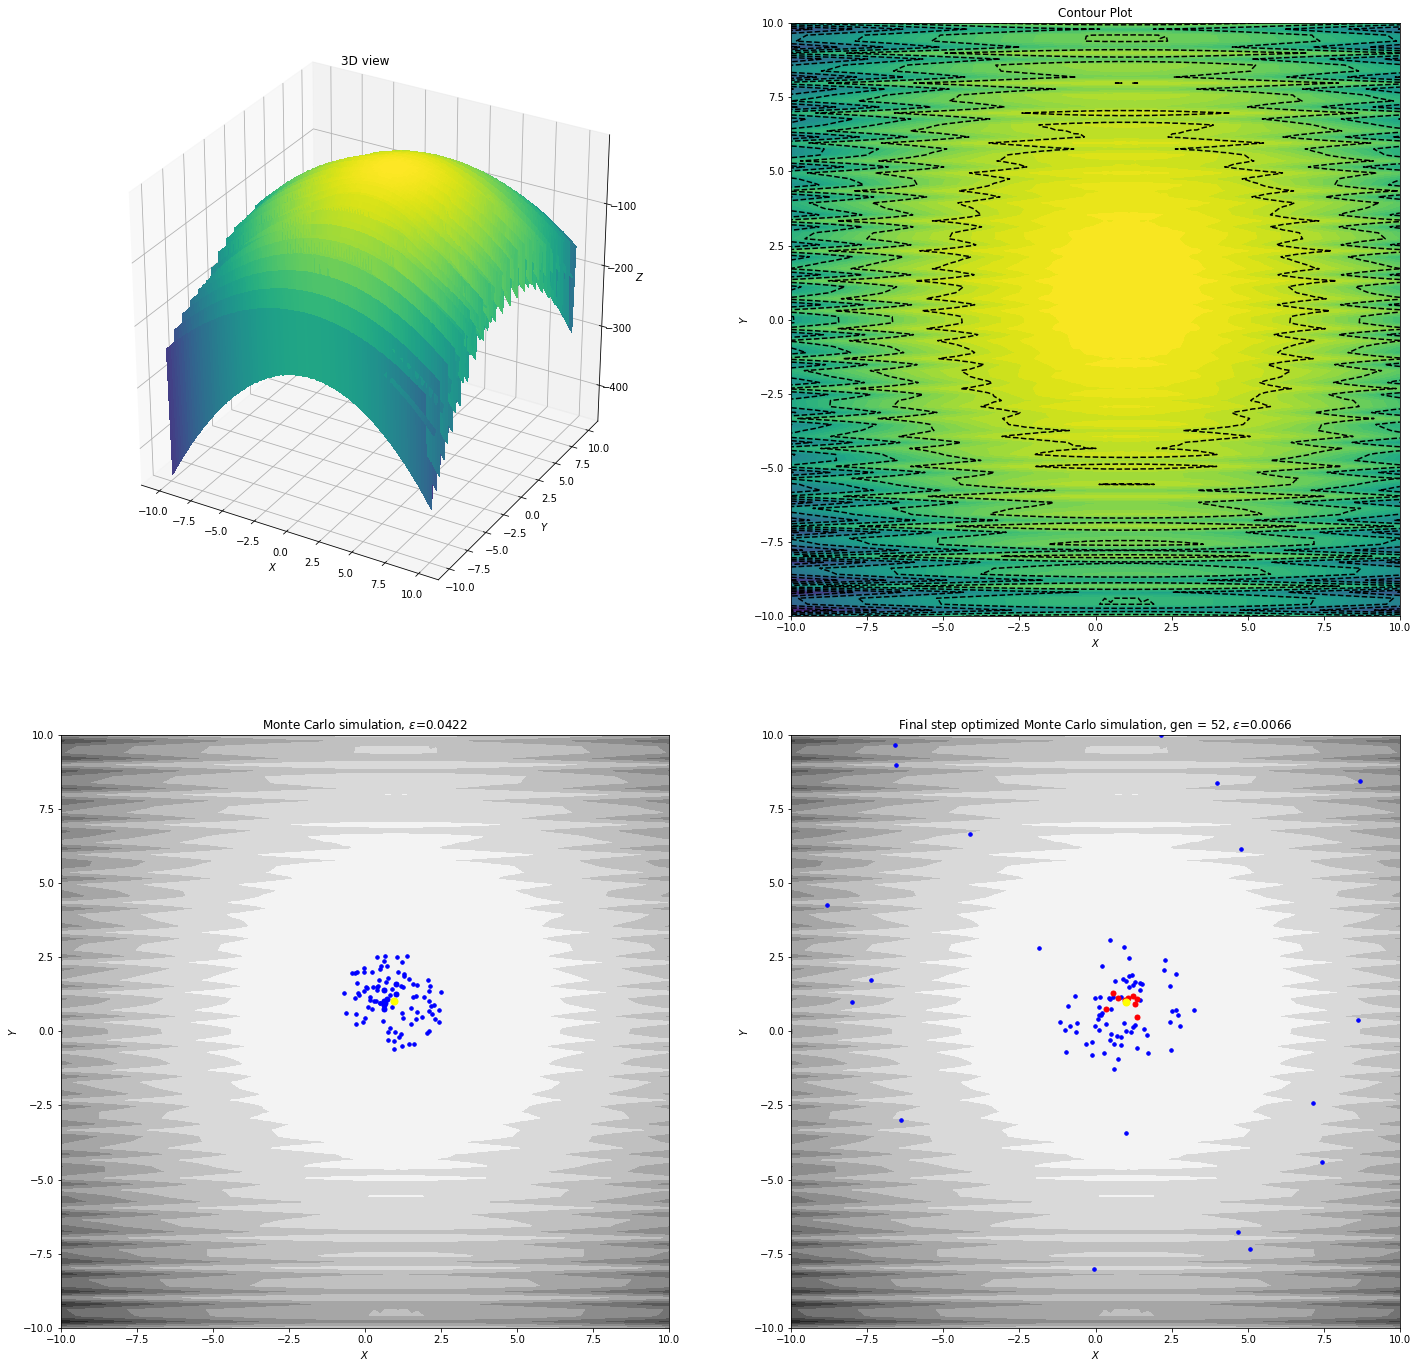

In [39]:
function_testing(levi, 100, 1e-2, 1000, [-10, 10], [-10, 10], [1, 1], 'y', 'n')

To do a fair comparison, the classical Monte Carlo method has been run with as many points as the optimized Monte Carlo method has used to reach either the desired tolerance or the generation limit. Thus, for the functions $\texttt{Easom, Schaffer N.2}$ and $\texttt{Eggholder}$, the classical Monte Carlo method is preferred. This is due to the fact that there is not a smooth gradient that goes towards the maximum but a sharp maximum located in a zone with a lot of valleys and mountains. 
However, in reality, functions are not that crazy and in the functions $\texttt{Ackley, Beale}$ and $\texttt{Levi N.13}$, the results are better in the optimized Monte Carlo simulation. 